In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GroupShuffleSplit, StratifiedGroupKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.inspection import permutation_importance


from scipy.stats import zscore # Necesario para los outliers
# Importación de tu clase personalizada
from class_imbalance import ImbalanceHandler

# Configuración de reproducibilidad
torch.manual_seed(42)
np.random.seed(42)

El dataset seleccionat té valors ordenats segons el temps, de manera que per predir la clase, pot ser relevant utilitzar dades de instants anteriors, això es referit com a "lag features". A continuació farem un estudi de la correlació entre les features abans de crear les "lag features".  

In [13]:
# Parámetros
NUM_LAGS = 5
COLUMNAS_A_ELIMINAR = ['Num', 'Timestamp'] 

# Carga de datos
df = pd.read_csv('robot_dataset.csv')
df.columns = df.columns.str.strip() # Eliminar espacios en blanco de los nombres de las columnas

#Crear Target Combinado (0 a 3)
#0: OK | 1: Grip Lost | 2: Protective Stop | 3: Ambos
mapping = {'False': 0, 'True': 1, False: 0, True: 1}
stop = df['Robot_ProtectiveStop'].map(mapping)
grip = df['grip_lost'].map(mapping)
df['Status_Combined'] = (stop * 2) + grip

#Limpieza de columnas innecesarias
df_prep = df.drop(columns=COLUMNAS_A_ELIMINAR + ['Robot_ProtectiveStop', 'grip_lost'], errors='ignore')
df_prep = df_prep.dropna().copy()

#Generación dinámica de Lags
sensor_cols = [col for col in df_prep.columns if any(x in col for x in ['Current', 'Temperature', 'Speed', 'Tool_current'])]

for col in sensor_cols:
    for i in range(1, NUM_LAGS + 1):
        df_prep[f'{col}lag{i}'] = df_prep.groupby('cycle')[col].shift(i)

#Eliminación de filas nulas por los lags
df_final = df_prep.dropna().copy()
df_final = df_final[df_final['Status_Combined'] != 3].copy()

#Split por CICLOS (GroupShuffleSplit)
groups = df_final['cycle'].values
gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
#Definir X (features) e y (target 0-3)
X = df_final.drop(columns=['Status_Combined', 'cycle']).values
y = df_final['Status_Combined'].values
train_idx, test_idx = next(gss.split(X, y, groups=groups))

df_train, df_test = df_final.iloc[train_idx], df_final.iloc[test_idx]

print(f"--- PREPROCESAMIENTO COMPLETADO ---")
print(f"Forma final del dataset: {df_final.shape}")
print(f"Distribución de clases (Target):\n{df_final['Status_Combined'].value_counts()}")


X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]
groups_train = groups[train_idx]

#Escalar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


#Creamos DataFrames separados.
df_train = df_prep.iloc[train_idx].copy()
df_test = df_prep.iloc[test_idx].copy()

--- PREPROCESAMIENTO COMPLETADO ---
Forma final del dataset: (6152, 116)
Distribución de clases (Target):
Status_Combined
0.0    5733
1.0     215
2.0     204
Name: count, dtype: int64


In [14]:
df

,Num,Timestamp,Current_J0,Temperature_T0,Current_J1,Temperature_J1,Current_J2,Temperature_J2,Current_J3,Temperature_J3,Current_J4,Temperature_J4,Current_J5,Temperature_J5,Speed_J0,Speed_J1,Speed_J2,Speed_J3,Speed_J4,Speed_J5,Tool_current,cycle,Robot_ProtectiveStop,grip_lost,Status_Combined
0,1,2022-10-26T08:17:21.847Z,0.109628,27.8750,-2.024669,29.3750,-1.531442,29.3750,-0.998570,32.1250,-0.062540,32.2500,-0.152622,32.0000,2.955651e-01,-0.000490,0.001310,-0.132836,-0.007479,-0.152962,0.082732,1,False,False,0.0
1,2,2022-10-26T08:17:22.852Z,0.595605,27.8750,-2.278456,29.3125,-0.866556,29.4375,-0.206097,32.1875,-1.062762,32.2500,-0.260764,32.0000,-7.390000e-30,-0.000304,0.002185,0.001668,-0.000767,0.000417,0.505895,1,False,False,0.0
2,3,2022-10-26T08:17:23.857Z,-0.229474,27.8750,-2.800408,29.3125,-2.304336,29.4375,-0.351499,32.1250,-0.668869,32.3125,0.039071,32.0625,1.369386e-01,0.007795,-2.535874,0.379867,0.000455,-0.496856,0.079420,1,False,False,0.0
3,4,2022-10-26T08:17:24.863Z,0.065053,27.8750,-3.687768,29.3125,-1.217652,29.4375,-1.209115,32.1250,-0.819755,32.2500,0.153903,32.0000,-9.030032e-02,-0.004911,-0.009096,-0.384196,0.018411,0.425559,0.083325,1,False,False,0.0
4,5,2022-10-26T08:17:25.877Z,0.884140,27.8750,-2.938830,29.3750,-1.794076,29.4375,-2.356471,32.1875,-0.966427,32.3125,0.178998,32.0000,1.268088e-01,0.005567,0.001138,-0.353284,0.014994,0.180989,0.086379,1,False,False,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7404,7405,2022-10-26T15:36:02.555Z,-0.109017,37.1875,-2.261695,40.3125,-1.082678,40.6875,-0.494714,43.3750,-0.019447,45.2500,0.023025,44.5625,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.080013,264,False,False,0.0
7405,7406,2022-10-26T15:36:03.562Z,-0.098536,37.1875,-2.251992,40.3125,-1.094420,40.6875,-0.515789,43.3750,-0.009186,45.2500,0.047794,44.5000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.078740,264,False,False,0.0
7406,7407,2022-10-26T15:36:04.571Z,-0.121100,37.1875,-2.280791,40.2500,-1.121319,40.6875,-0.502406,43.3750,-0.002978,45.2500,0.028567,44.5000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.091471,264,False,False,0.0
7407,7408,2022-10-26T15:36:05.572Z,-0.129370,37.1875,-2.269061,40.3125,-1.091610,40.6250,-0.491158,43.3750,-0.001136,45.2500,0.049641,44.5625,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.090026,264,False,False,0.0


## Estudi del dataset

El dataset contiene informacion de 5 joints. Cada joint tiene 3 sensores:
- Corriente (Current)
- Temperatura (Temperature)
- Velociodad (Velocity)

<Figure size 1200x1000 with 0 Axes>

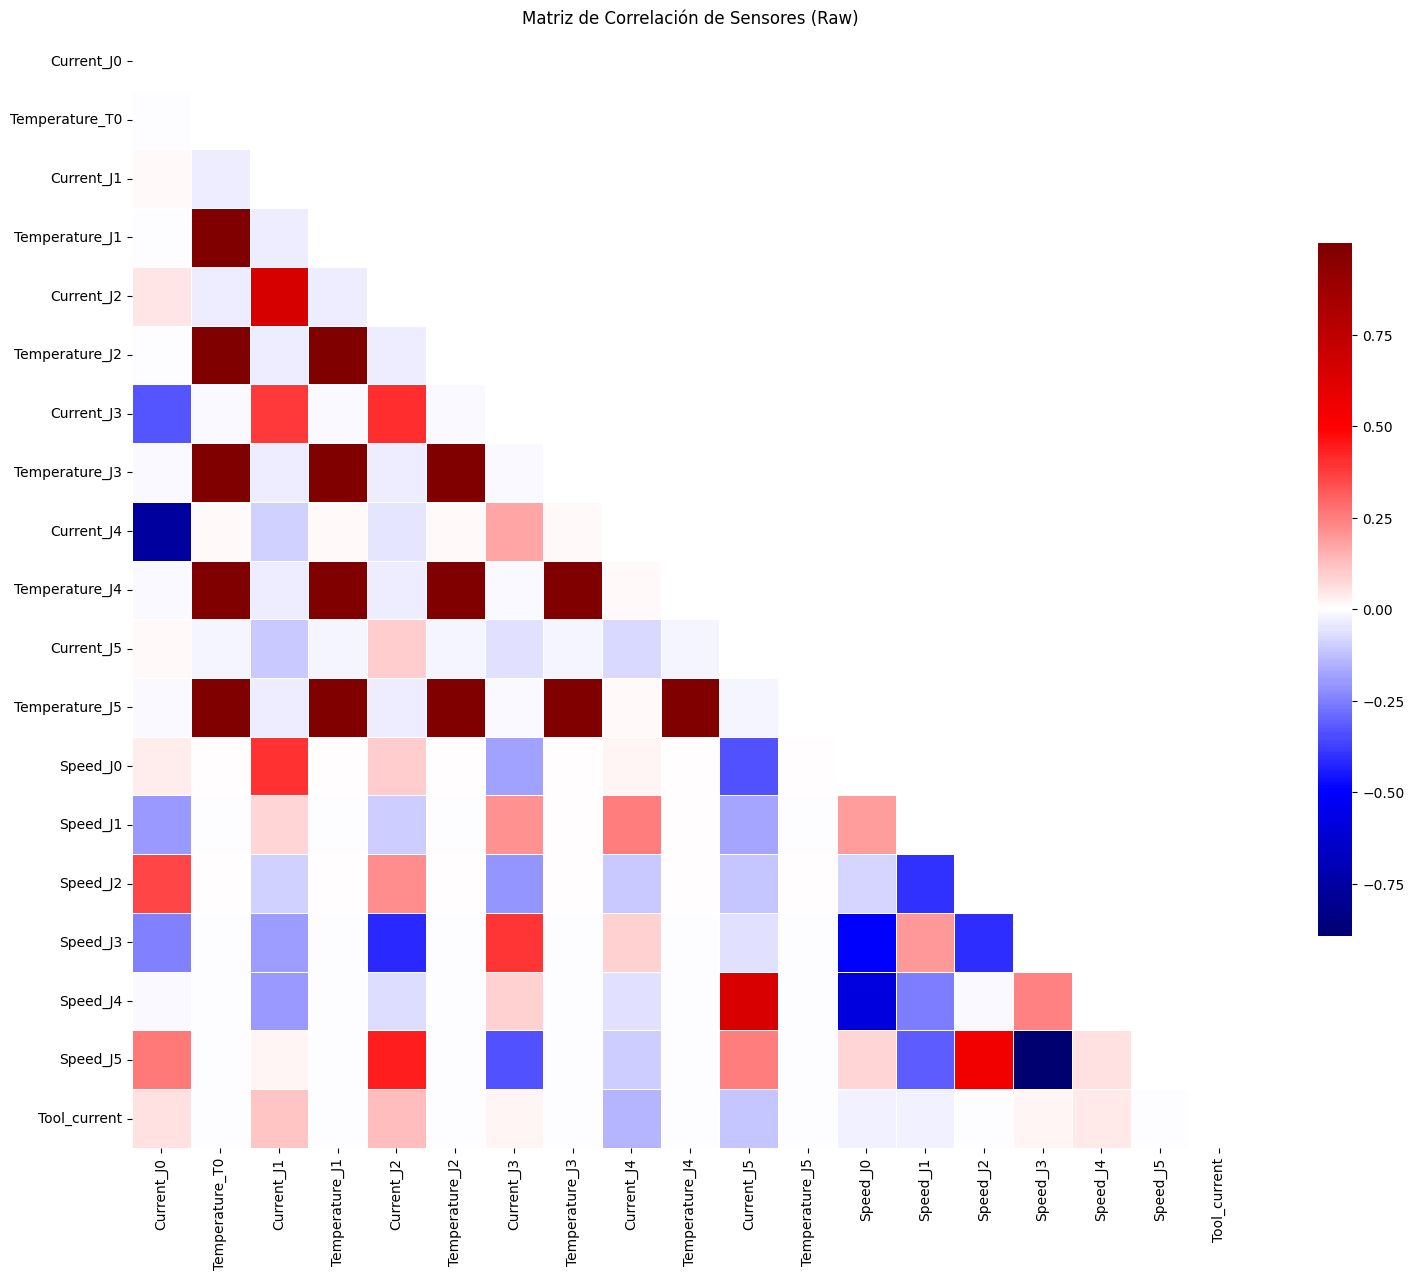

In [16]:
plt.figure(figsize=(12, 10))
corr = df_train[sensor_cols].corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.subplots(figsize=(18, 18))
sns.heatmap(corr, mask=mask, cmap='seismic',  center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});
plt.title("Matriz de Correlación de Sensores (Raw)")
plt.show()

En el heatmap anterior se puede observar la correlacion entre las distintas variables. Se puede encontrar una alta correlacion entre la temperatura de los distintos sensores, es decir, cuando la temperatura de un sensor aumenta, la de los otros sensores también tiende a aumentar. Exactamente lo msimo ocurre con la corriente y la velocidad, cuando la velocidad de un sensor aumenta, su velocidad también lo hace.

De manera que tenemos variables altamente correlacionadas entre sí, mas adelante haremos un estudio de reducción de dimensionalidad.

## Autocorrelació en el temps de sensors.
Estudio de autocorrelacion en el tiempo para cada sensor. El objetivo es determinar el número adecuado de lags a utilizar en la creación de features de **lag**.

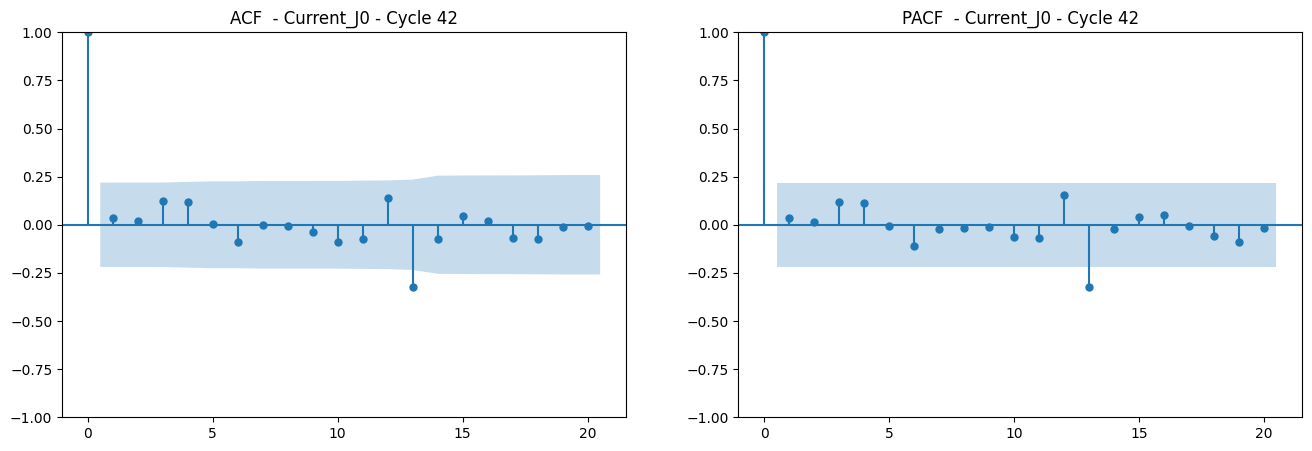

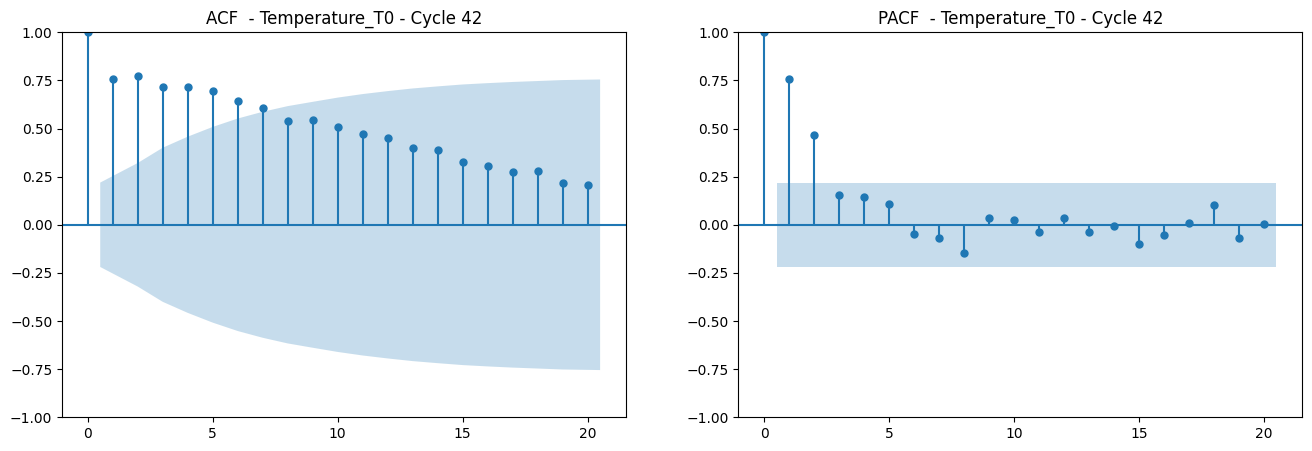

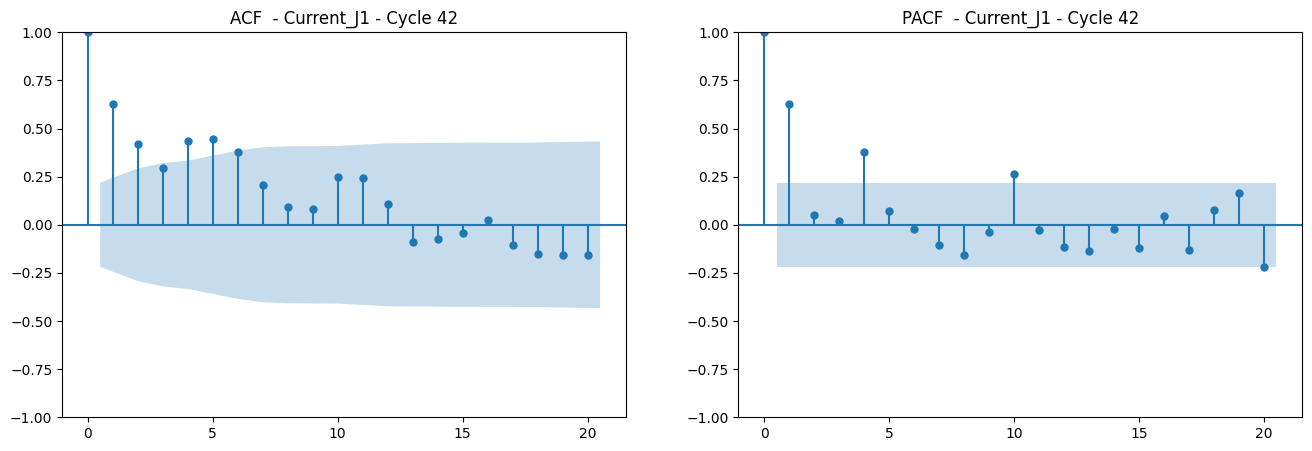

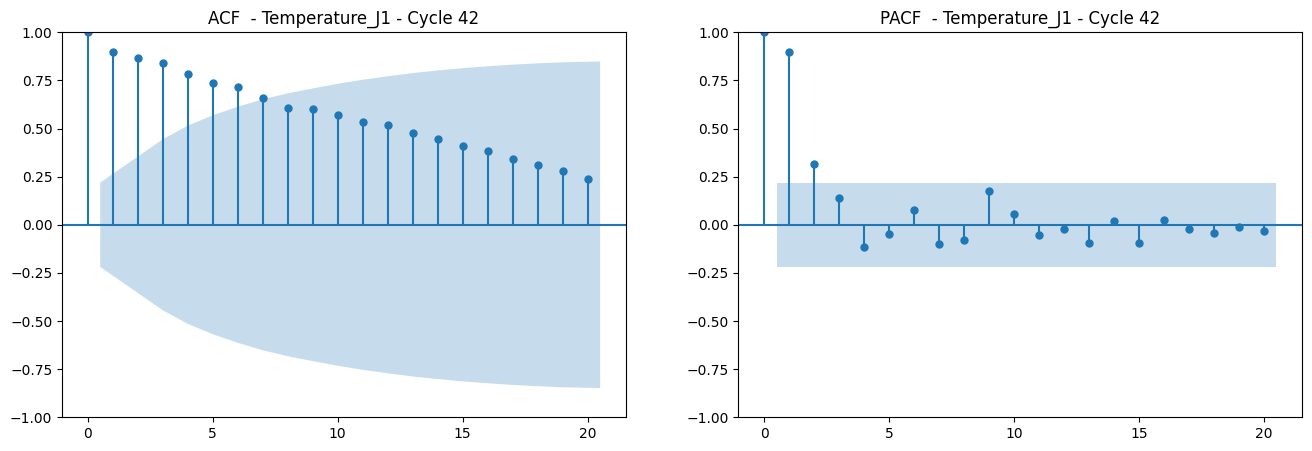

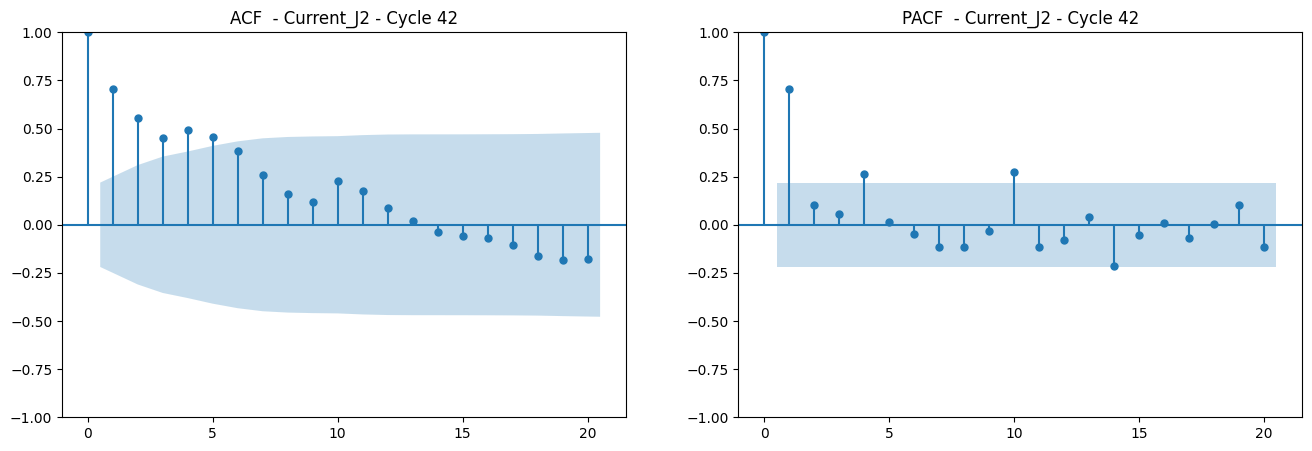

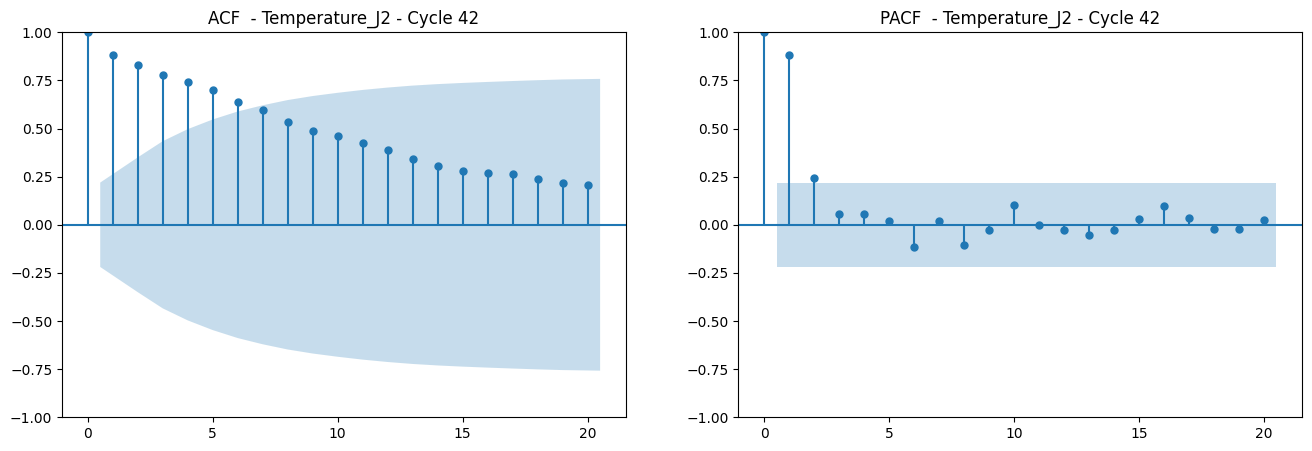

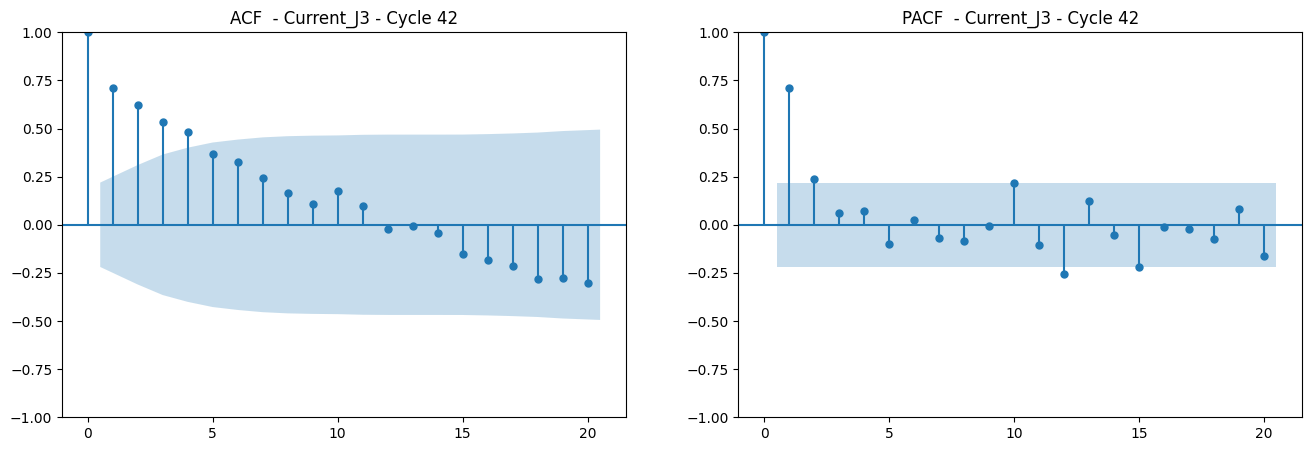

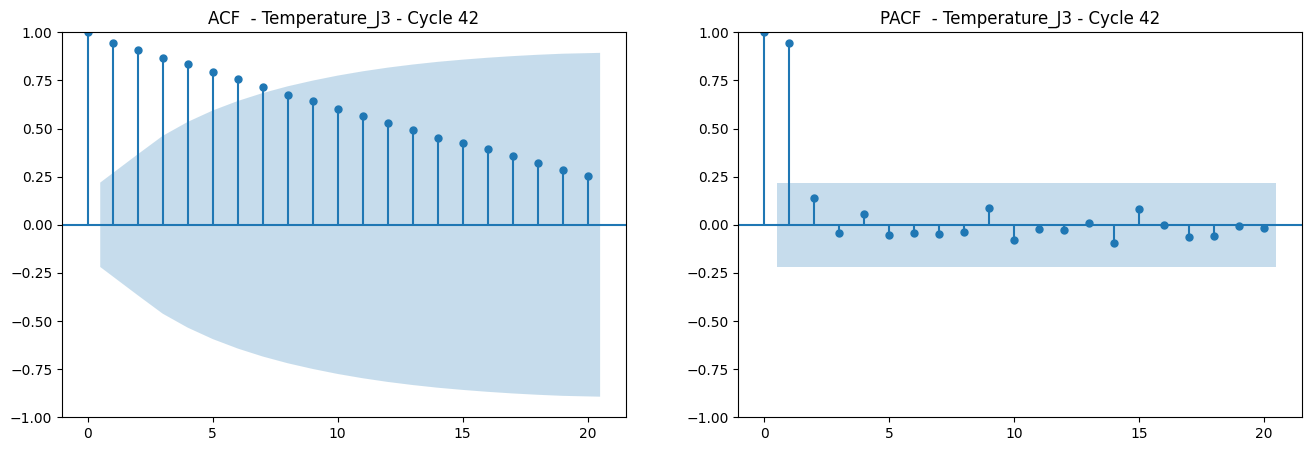

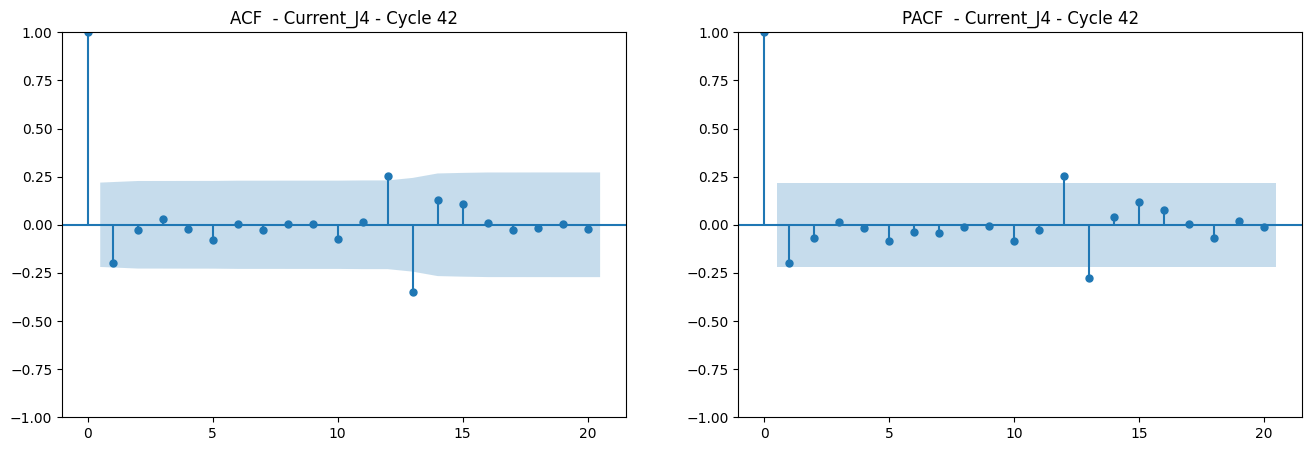

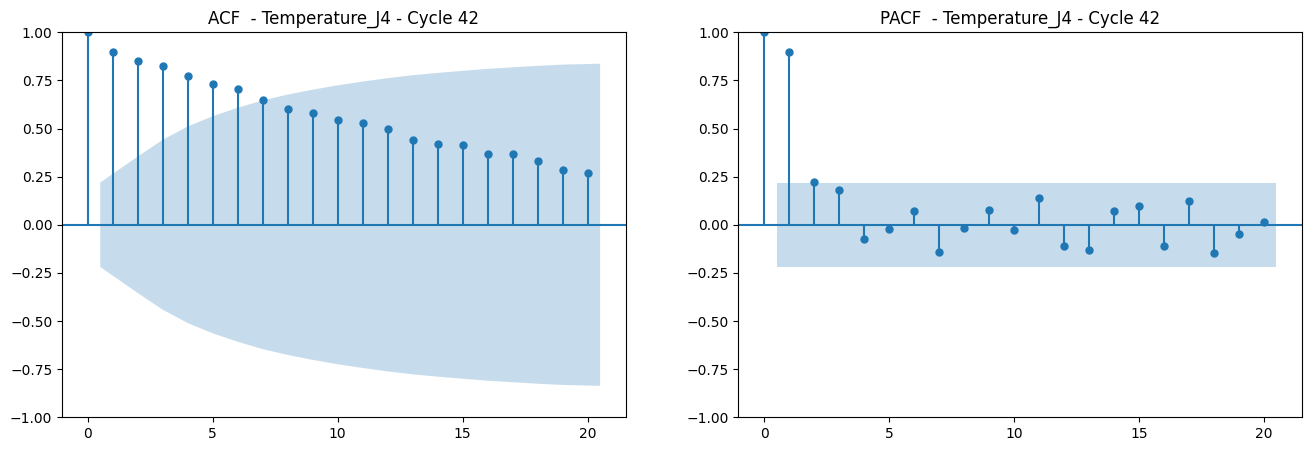

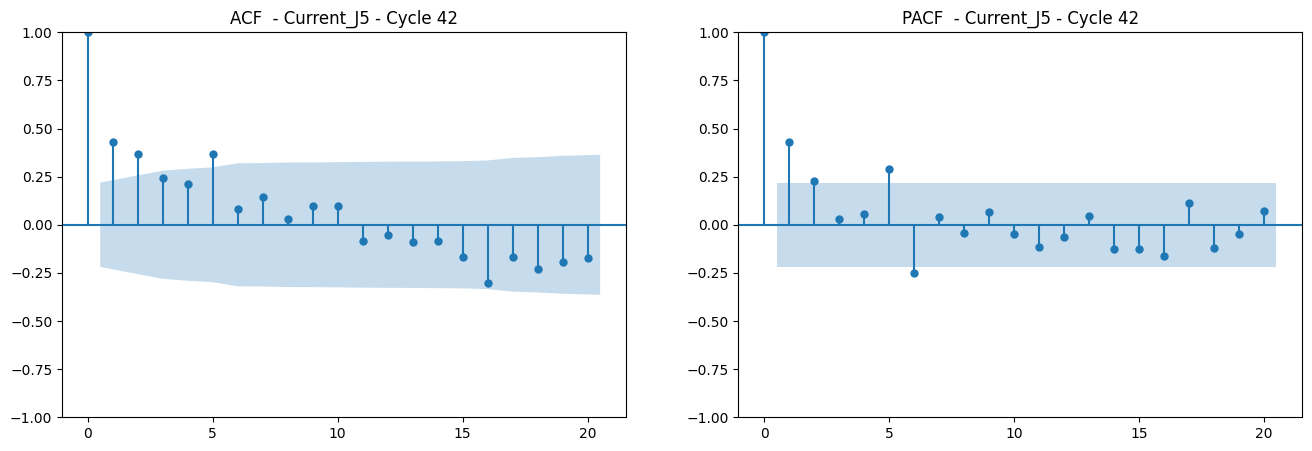

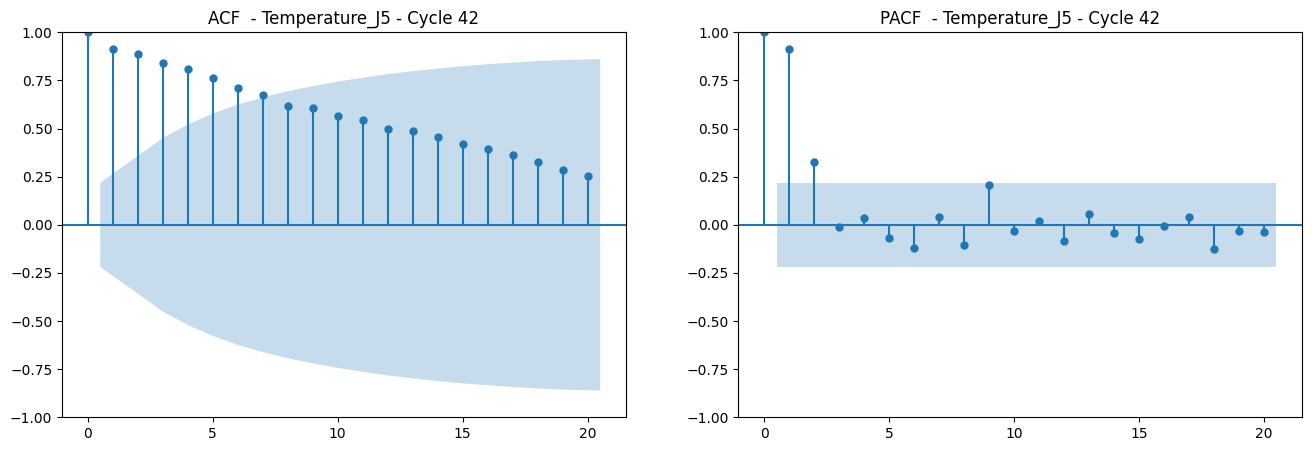

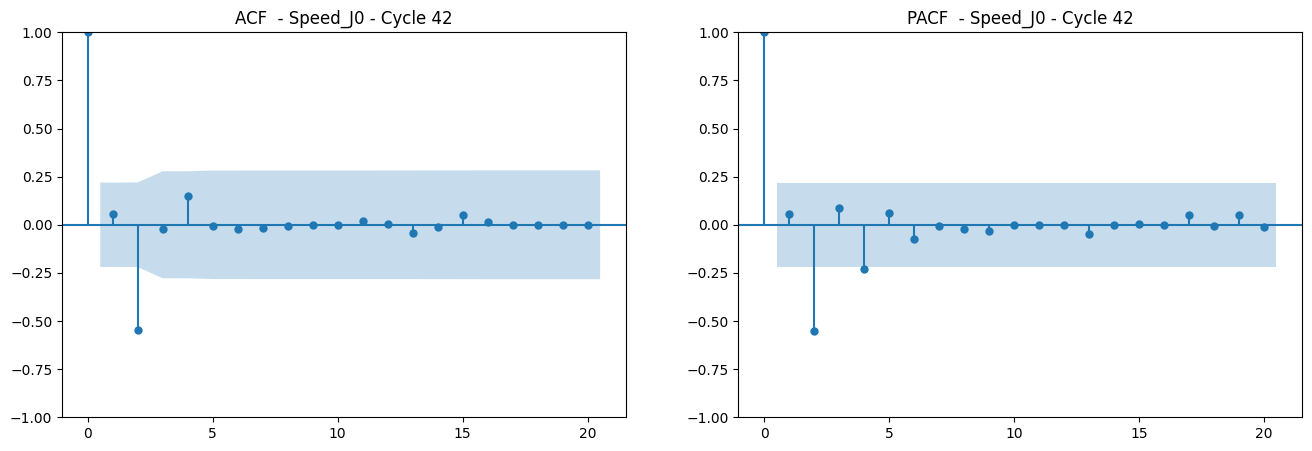

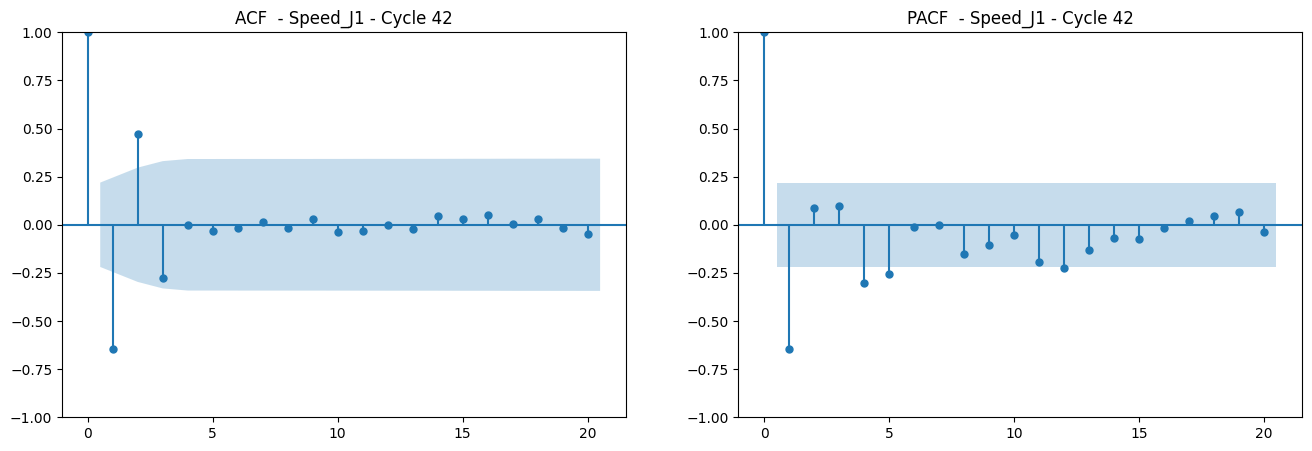

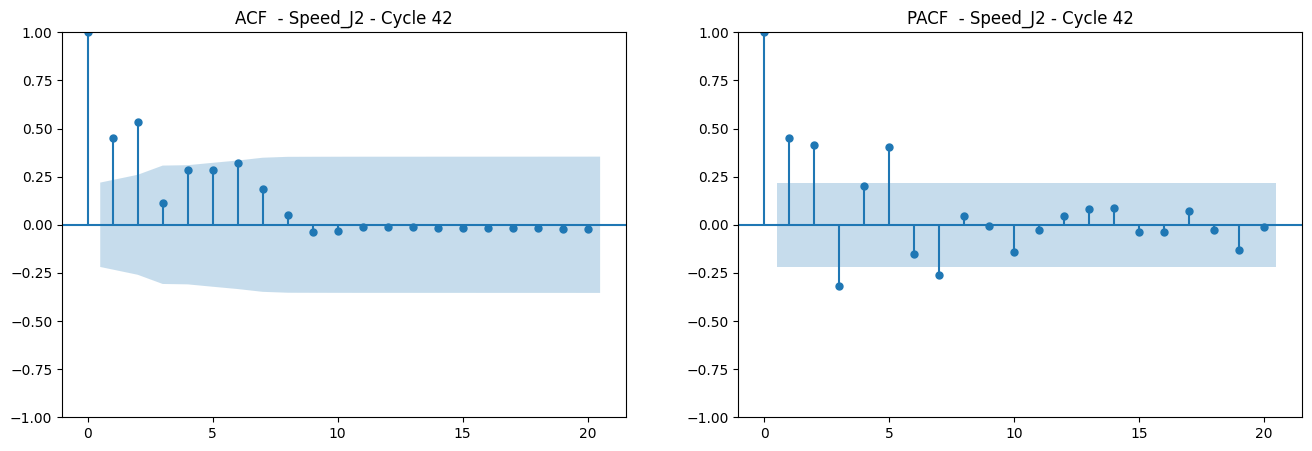

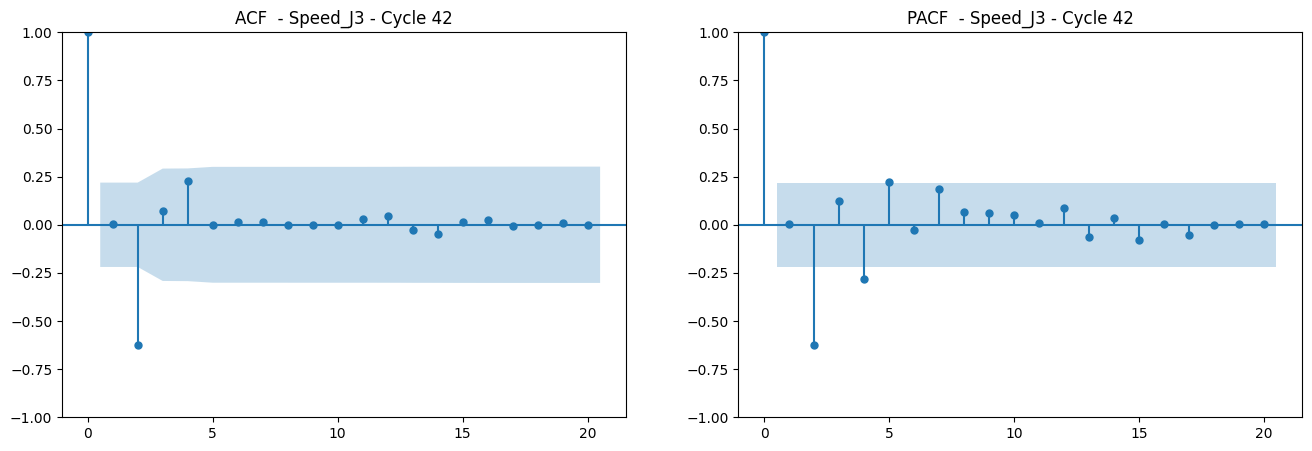

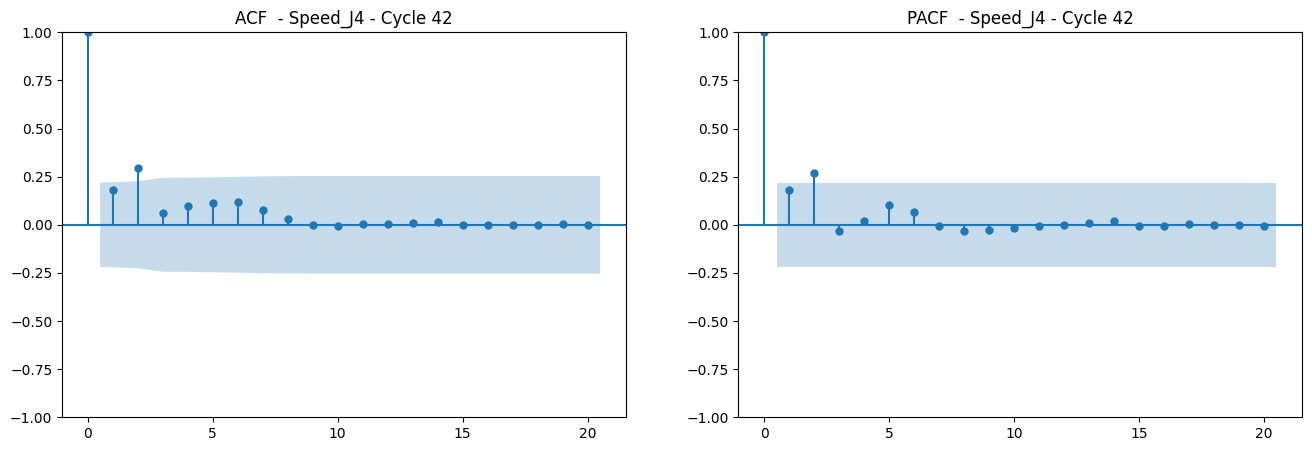

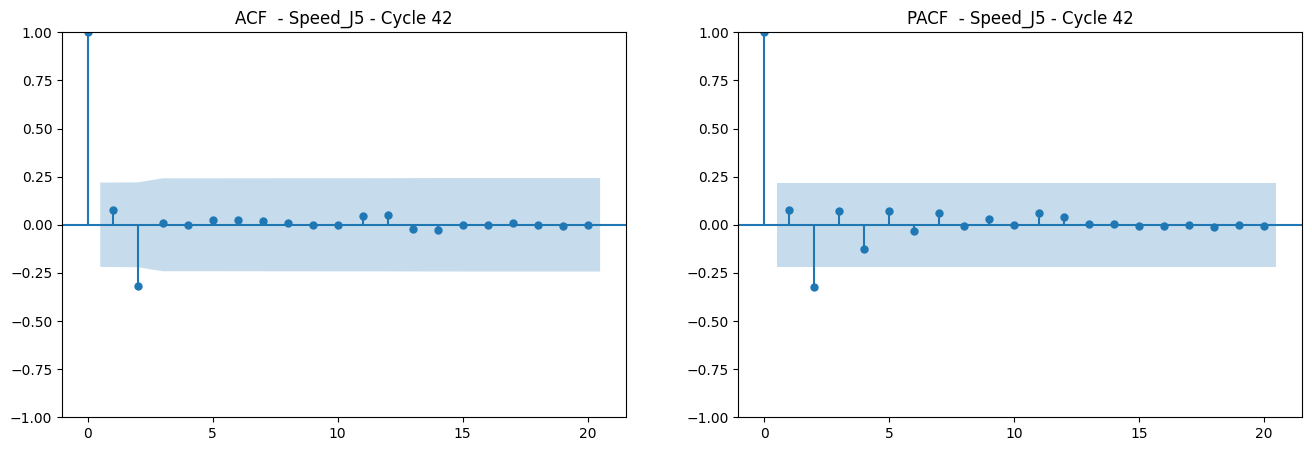

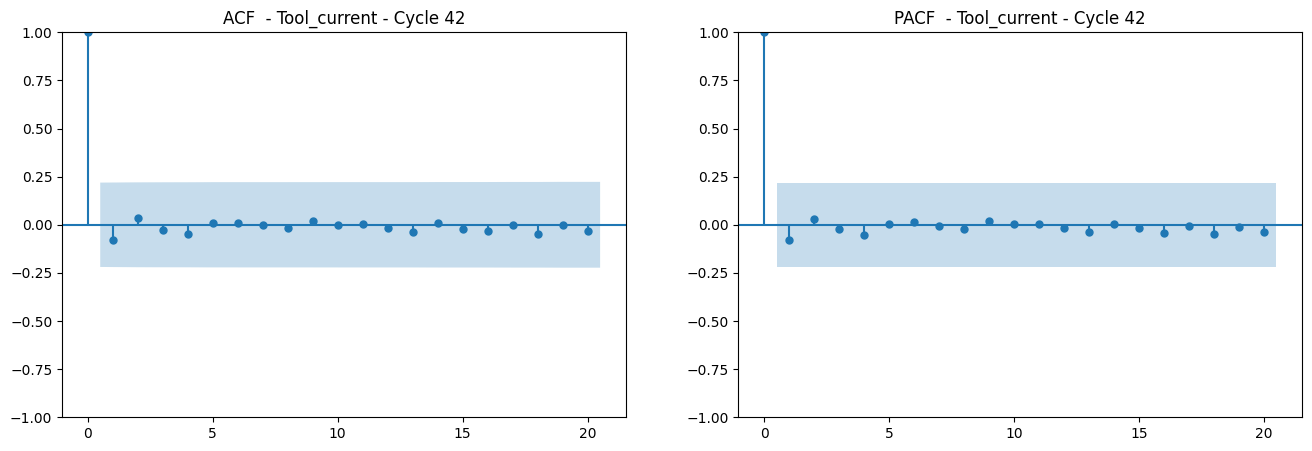

In [ ]:
cycle_counts = df_train['cycle'].value_counts()
longest_cycle_id = cycle_counts.idxmax()
longest_cycle_len = cycle_counts.max()

for i, feature_name in enumerate(sensor_cols):
    sensor_demo = sensor_cols[i] 
    series_demo = df_train[df_train['cycle'] == longest_cycle_id][sensor_demo]

    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    plot_acf(series_demo, lags=20, ax=ax[0], title=f'ACF  - {feature_name} - Cycle {longest_cycle_id}')
    plot_pacf(series_demo, lags=20, ax=ax[1], title=f'PACF  - {feature_name} - Cycle {longest_cycle_id}')
    plt.show()


**Justificación de Lags (Ventana Temporal):**

A pesar de que algunos de los sensores no muestran una autocorrelación significativa, sobretodo los de velocidad (esto seguramente se deba a que las muestras se toman cada un segundo y la velocidad puede cambiar rápidamente), la mayoría de sensores físicos presentan cierta dependencia temporal con sus estados anteriores.

Basándonos en el gráfico de **PACF** (Autocorrelación Parcial), que mide la relación directa pura entre instantes, observamos que la "memoria" del sistema se desvanece tras los primeros instantes. Hemos decidido estandarizar el modelo con **5 lags**. Esta ventana es lo suficientemente amplia para cubrir la inercia de los sensores más complejos sin introducir excesivo ruido en los sensores más simples.

### Analisis de dimensionalidad y Relevancioa con 5-LAG

/tmp/ipykernel_157637/3518527575.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.head(20).values, y=correlations.head(20).index, palette='magma')


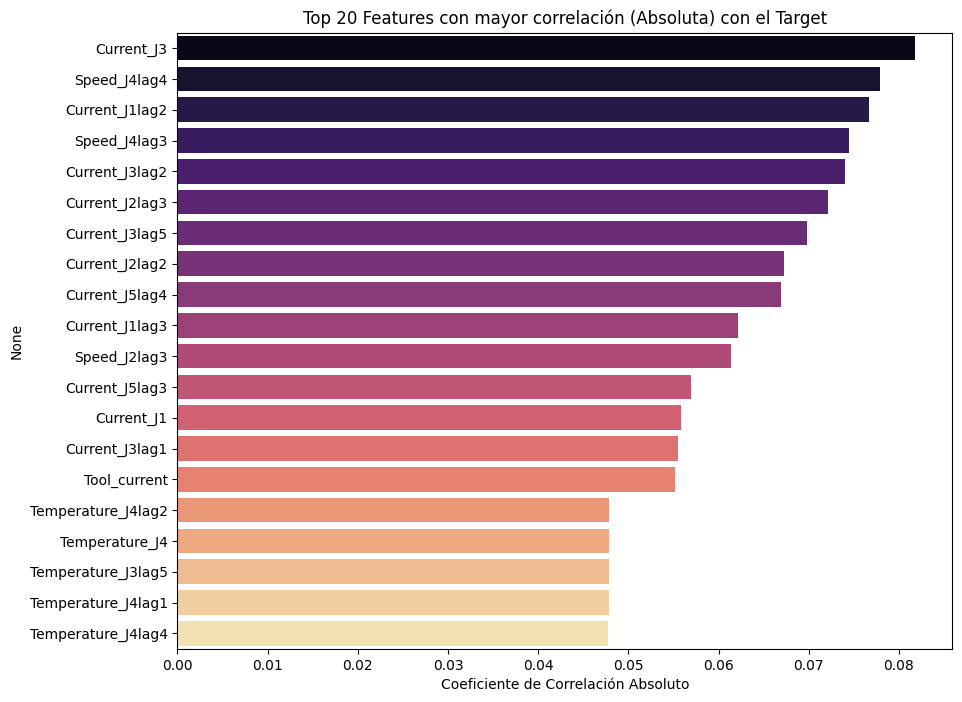

Interpretación: Las barras más largas indican las variables (y sus lags) que más ayudan al modelo a distinguir si hay un fallo o no.

--- RESULTADOS PCA ---
Features originales (con Lags): 114
Componentes necesarios para 95% varianza: 40
Ratio de compresión: 2.9x


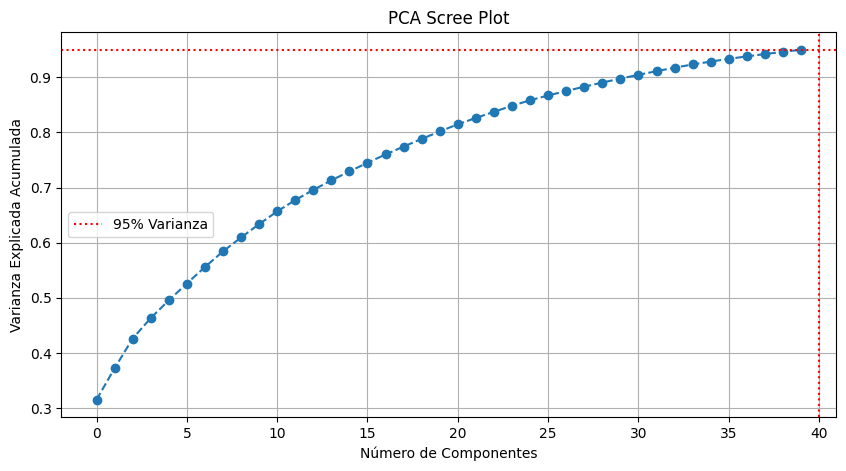

Calculando t-SNE sobre 2000 muestras (usando inputs de PCA)...


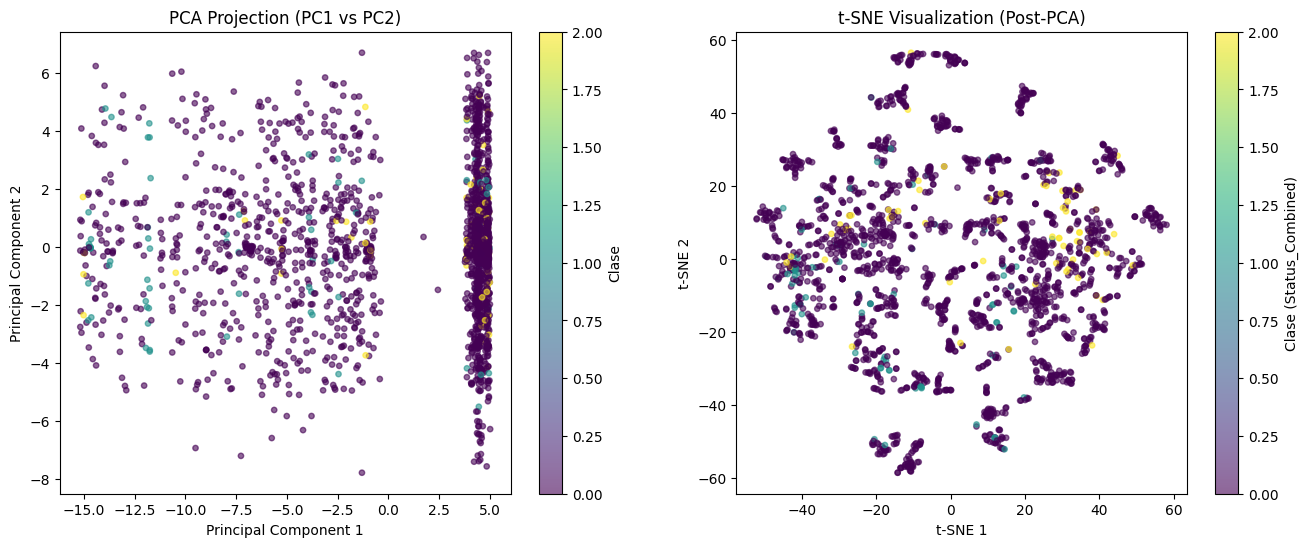

In [ ]:

# 1. CORRELACIÓN CON EL TARGET (Top 20 Features)
# Reconstruimos un DF temporal solo para análisis (X_train ya está escalado)
df_analysis = pd.DataFrame(X_train_scaled, columns=df_train.drop(columns=['Status_Combined', 'cycle']).columns)

# Añadimos el target temporalmente para calcular la correlación
df_analysis['TARGET'] = y_train

# Calculamos la correlación con el TARGET
correlations = df_analysis.corrwith(df_analysis['TARGET']).abs()

correlations = correlations.drop('TARGET', errors='ignore')

# Ordenamos
correlations = correlations.sort_values(ascending=False)

# Visualizamos las 20 más importantes
plt.figure(figsize=(10, 8))
sns.barplot(x=correlations.head(20).values, y=correlations.head(20).index, palette='magma')
plt.title('Top 20 Features con mayor correlación (Absoluta) con el Target')
plt.xlabel('Coeficiente de Correlación Absoluto')
plt.show()

print("Interpretación: Las barras más largas indican las variables (y sus lags) que más ayudan al modelo a distinguir si hay un fallo o no.")

pca = PCA(n_components=0.95) 
X_pca = pca.fit_transform(X_train_scaled)

n_components = pca.n_components_
explained_variance = np.sum(pca.explained_variance_ratio_)

print(f"\n--- RESULTADOS PCA ---")
print(f"Features originales (con Lags): {X_train_scaled.shape[1]}")
print(f"Componentes necesarios para 95% varianza: {n_components}")
print(f"Ratio de compresión: {X_train_scaled.shape[1] / n_components:.1f}x")

# Scree Plot (Varianza acumulada)
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.axhline(y=0.95, color='r', linestyle=':', label='95% Varianza')
plt.axvline(x=n_components, color='r', linestyle=':')
plt.xlabel('Número de Componentes')
plt.ylabel('Varianza Explicada Acumulada')
plt.title('PCA Scree Plot')
plt.legend()
plt.grid(True)
plt.show()

N_SAMPLES_VIZ = 2000

if X_train_scaled.shape[0] > N_SAMPLES_VIZ:
    # Stratified subsample
    indices = np.arange(X_train_scaled.shape[0])
    _, idx_sub = train_test_split(indices, test_size=N_SAMPLES_VIZ, stratify=y_train, random_state=42)
    X_sub_tsne_input = X_pca[idx_sub] 
    y_sub = y_train[idx_sub]
    X_sub_pca = X_pca[idx_sub] # Usamos la proyección PCA correspondiente
else:
    X_sub_tsne_input = X_pca
    y_sub = y_train
    X_sub_pca = X_pca

# T-SNE Plot
print(f"Calculando t-SNE sobre {len(X_sub_tsne_input)} muestras (usando inputs de PCA)...")
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_jobs=-1)
X_tsne = tsne.fit_transform(X_sub_tsne_input)

plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
scatter = plt.scatter(X_sub_pca[:, 0], X_sub_pca[:, 1], c=y_sub, cmap='viridis', alpha=0.6, s=15)
plt.title('PCA Projection (PC1 vs PC2)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Clase')

plt.subplot(1, 2, 2)
scatter2 = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_sub, cmap='viridis', alpha=0.6, s=15)
plt.title('t-SNE Visualization (Post-PCA)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.colorbar(scatter2, label='Clase (Status_Combined)')
plt.show()



Separación por ciclos para evitar un tipo de overfitting temporal. El objetivo es predecir si en un nuevo ciclo hay algun fallo, no tiene sentido entrenar al modelo con un ciclo y luego intentar predecir algo de ese mismo ciclo.

### Modelos Lineales

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# 1. Configuración de Grillas de Parámetros
param_grid_log = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga']
}

grid_log = GridSearchCV(
    LogisticRegression(class_weight='balanced', max_iter=5000),
    param_grid_log, 
    cv=StratifiedGroupKFold(n_splits=5), 
    scoring='f1_macro',
    n_jobs=-1
)

print("Buscando mejores parámetros para Regresión Logística...")
grid_log.fit(X_train_scaled, y_train, groups=groups_train)


# Comparación
best_log = grid_log.best_estimator_

best_model = grid_log.best_estimator_
model_name = "Regresión Logística"
params = grid_log.best_params_

print(f"\n--- MEJOR MODELO ENCONTRADO: {model_name} ---")
print(f"Parámetros: {params}")

# Predicción y Reporte con X_test_scaled
y_pred = best_model.predict(X_test_scaled)
print("\nReporte de Clasificación Final:")
print(classification_report(y_test, y_pred))

Buscando mejores parámetros para Regresión Logística...


/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which 


--- MEJOR MODELO ENCONTRADO: Regresión Logística ---
Parámetros: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}

Reporte de Clasificación Final:
              precision    recall  f1-score   support

         0.0       0.98      0.62      0.76      1784
         1.0       0.10      0.80      0.18        44
         2.0       0.11      0.66      0.18        64

    accuracy                           0.63      1892
   macro avg       0.39      0.69      0.37      1892
weighted avg       0.93      0.63      0.73      1892



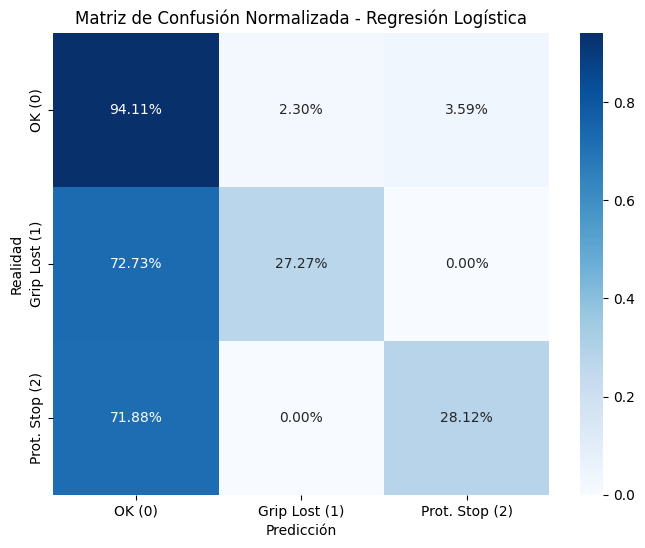

/tmp/ipykernel_157637/2785479954.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20), palette='viridis')


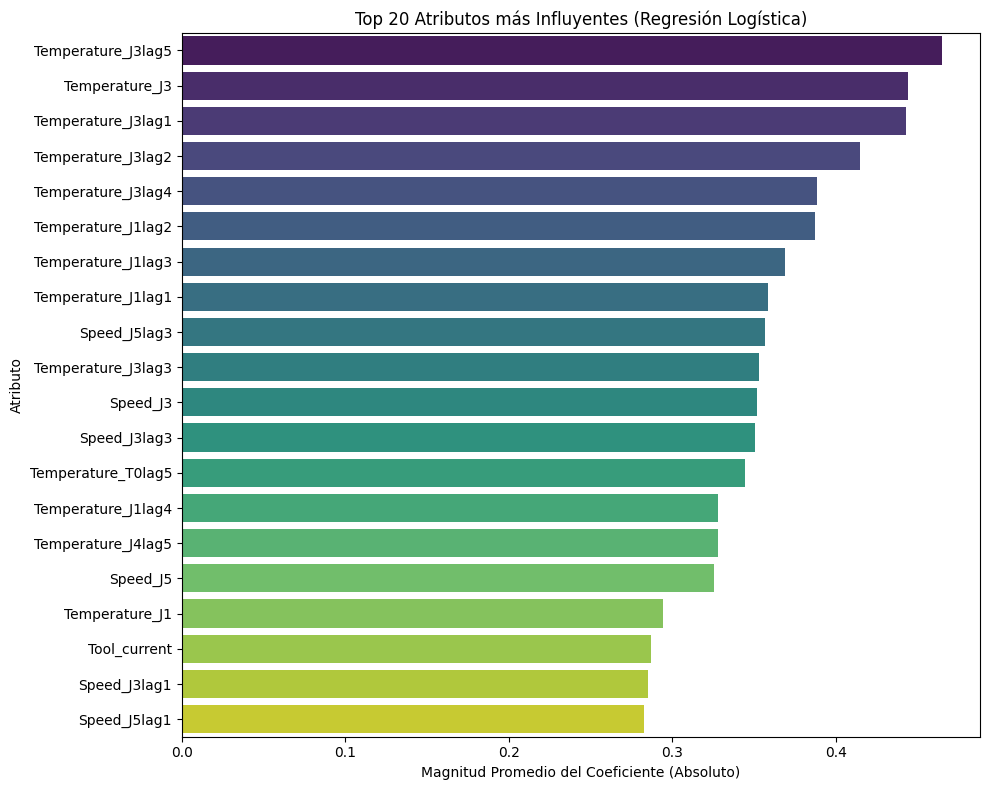


Top 5 atributos que MÁS aumentan la probabilidad de Protective Stop (Clase 2):
                Feature      Coef
36   Temperature_J1lag3  0.650262
106        Speed_J5lag3  0.627783
96         Speed_J3lag3  0.594152
104        Speed_J5lag1  0.584892
105        Speed_J5lag2  0.570032


In [ ]:
conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='.2%', cmap='Blues', 
            xticklabels=['OK (0)', 'Grip Lost (1)', 'Prot. Stop (2)'],
            yticklabels=['OK (0)', 'Grip Lost (1)', 'Prot. Stop (2)'])
plt.title('Matriz de Confusión Normalizada - Regresión Logística')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()


# 2. IMPORTANCIA DE ATRIBUTOS (COEFICIENTES)
feature_names = df_final.drop(columns=['Status_Combined', 'cycle']).columns

# Calculamos la importancia media (magnitud absoluta de los coeficientes)
importances = np.mean(np.abs(best_model.coef_), axis=0)

# Crear DataFrame para la visualización
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Graficar los 20 más importantes
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20), palette='viridis')
plt.title('Top 20 Atributos más Influyentes (Regresión Logística)')
plt.xlabel('Magnitud Promedio del Coeficiente (Absoluto)')
plt.ylabel('Atributo')
plt.tight_layout()
plt.show()

# Opcional: Ver qué influye específicamente en el Protective Stop (Clase 2)
# prot_stop_importance = pd.DataFrame({
#     'Feature': feature_names,
#     'Coef': best_model.coef_[2]
# }).sort_values(by='Coef', ascending=False)

# print("\nTop 5 atributos que MÁS aumentan la probabilidad de Protective Stop (Clase 2):")
# print(prot_stop_importance.head(5))

In [ ]:
param_grid_svm = [
    {
        'loss': ['squared_hinge'],
        'penalty': ['l2'],
        'dual': [False, True], 
        'C': [0.1, 1, 10]
    },
    {
        'loss': ['hinge'],
        'penalty': ['l2'],
        'dual': [True],
        'C': [0.1, 1, 10]
    }
]

grid_svm = GridSearchCV(
    LinearSVC(class_weight='balanced', dual=False),
    param_grid_svm, 
    cv=StratifiedGroupKFold(n_splits=5), 
    scoring='f1_macro',
    n_jobs=-1
)

print("Buscando mejores parámetros para Linear SVM...")
grid_svm.fit(X_train_scaled, y_train, groups=groups_train)

best_svm = grid_svm.best_score_

best_model = grid_svm.best_estimator_
model_name = "Linear SVM"
params = grid_svm.best_params_

print(f"\n--- MEJOR MODELO ENCONTRADO: {model_name} ---")
print(f"Parámetros: {params}")

# Predicción y Reporte con X_test_scaled
y_pred = best_model.predict(X_test_scaled)
print("\nReporte de Clasificación Final:")
print(classification_report(y_test, y_pred))

Buscando mejores parámetros para Linear SVM...


/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iteration


--- MEJOR MODELO ENCONTRADO: Linear SVM ---
Parámetros: {'C': 0.1, 'dual': False, 'loss': 'squared_hinge', 'penalty': 'l2'}

Reporte de Clasificación Final:
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95      1784
         1.0       0.23      0.27      0.25        44
         2.0       0.22      0.28      0.25        64

    accuracy                           0.90      1892
   macro avg       0.47      0.50      0.48      1892
weighted avg       0.91      0.90      0.91      1892



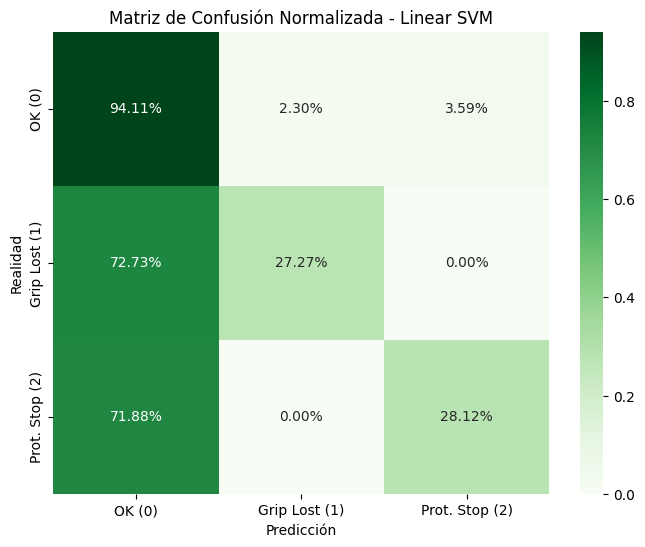

/tmp/ipykernel_157637/1120065630.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=svm_importance_df.head(20), palette='magma')


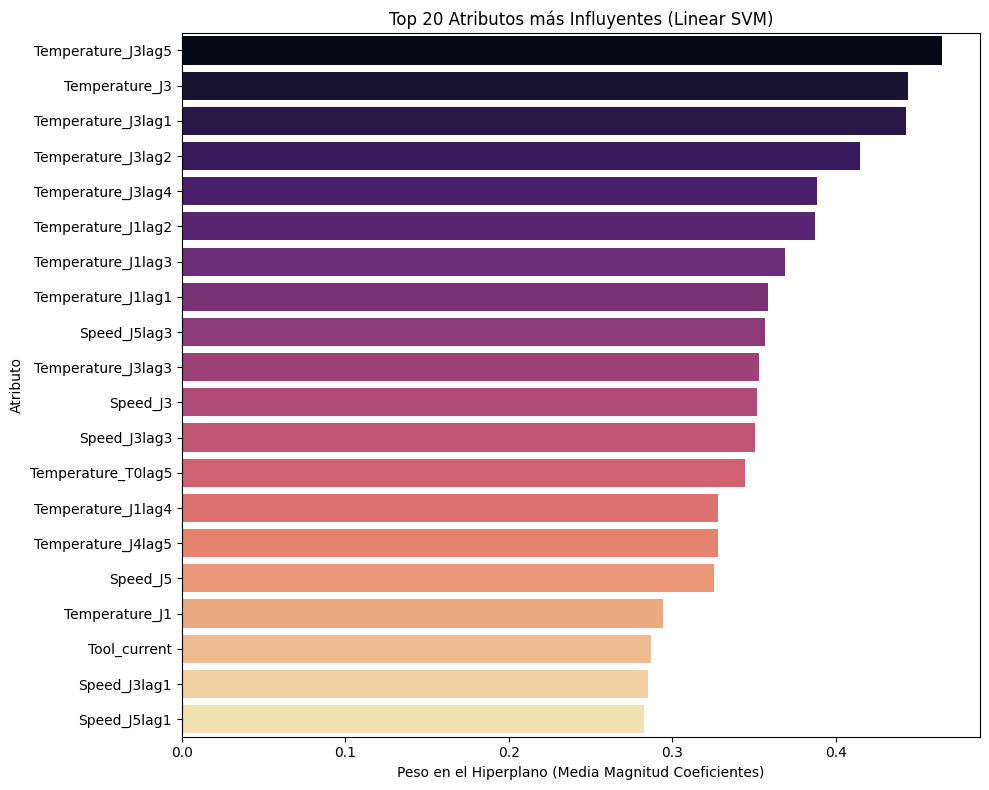


Top 5 atributos que empujan al SVM a predecir GRIP LOST (Clase 1):
               Feature      Coef
68  Temperature_J4lag5  0.623338
67  Temperature_J4lag4  0.433545
28  Temperature_T0lag5  0.426617
38  Temperature_J1lag5  0.393554
35  Temperature_J1lag2  0.376702


In [ ]:

conf_matrix_svm = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt='.2%', cmap='Greens', 
            xticklabels=['OK (0)', 'Grip Lost (1)', 'Prot. Stop (2)'],
            yticklabels=['OK (0)', 'Grip Lost (1)', 'Prot. Stop (2)'])
plt.title('Matriz de Confusión Normalizada - Linear SVM')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

# 2. IMPORTANCIA DE ATRIBUTOS (SVM)
feature_names = df_final.drop(columns=['Status_Combined', 'cycle']).columns

# Los coeficientes en LinearSVC tienen forma (n_clases, n_features)
# Calculamos la importancia global como la media de los valores absolutos
svm_importances = np.mean(np.abs(best_model.coef_), axis=0)

svm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': svm_importances
}).sort_values(by='Importance', ascending=False)

# Graficar los 20 más importantes
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=svm_importance_df.head(20), palette='magma')
plt.title('Top 20 Atributos más Influyentes (Linear SVM)')
plt.xlabel('Peso en el Hiperplano (Media Magnitud Coeficientes)')
plt.ylabel('Atributo')
plt.tight_layout()
plt.show()

In [ ]:
# %%
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# 'reg_param' que ayuda a estabilizar la covarianza si hay pocas muestras o colinealidad.
param_grid_qda = {
    'reg_param': [0.0, 0.01, 0.1, 0.5, 1.0]
}

# 2. Inicialización de GridSearch
grid_qda = GridSearchCV(
    QuadraticDiscriminantAnalysis(),
    param_grid_qda,
    cv=StratifiedGroupKFold(n_splits=5),
    scoring='f1_macro',
    n_jobs=-1
)

# 3. Entrenamiento
print("Entrenando QDA (Análisis Discriminante Cuadrático)...")
grid_qda.fit(X_train_scaled, y_train, groups=groups_train)

# 4. Resultados
best_qda = grid_qda.best_estimator_
print(f"\n--- MEJOR MODELO QDA ---")
print(f"Mejores Parámetros: {grid_qda.best_params_}")

# Predicción
y_pred_qda = best_qda.predict(X_test_scaled)
print("\nReporte de Clasificación (QDA):")
print(classification_report(y_test, y_pred_qda))

Entrenando QDA (Análisis Discriminante Cuadrático)...


/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/adria/UPC/7e_quatri/APA/APA_F


--- MEJOR MODELO QDA ---
Mejores Parámetros: {'reg_param': 0.01}

Reporte de Clasificación (QDA):
              precision    recall  f1-score   support

         0.0       0.97      0.69      0.81      1784
         1.0       0.09      0.80      0.15        44
         2.0       0.17      0.55      0.26        64

    accuracy                           0.69      1892
   macro avg       0.41      0.68      0.41      1892
weighted avg       0.92      0.69      0.78      1892



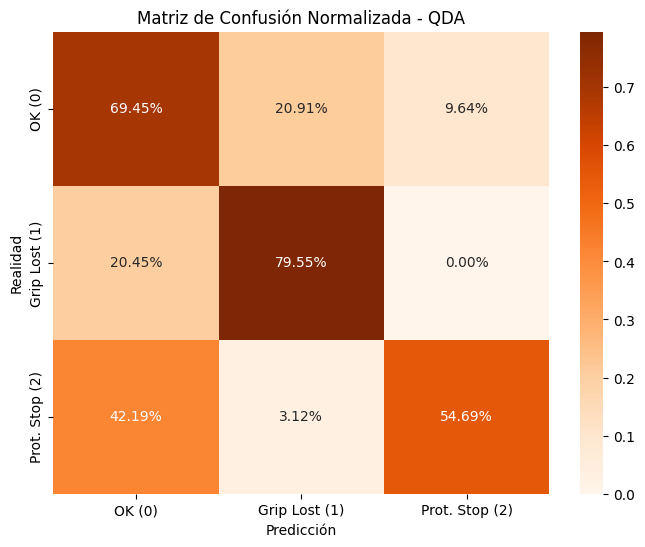

Calculando importancia por permutación (esto puede tardar unos segundos)...


/tmp/ipykernel_157637/419930306.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=qda_importance_df.head(20), palette='flare')


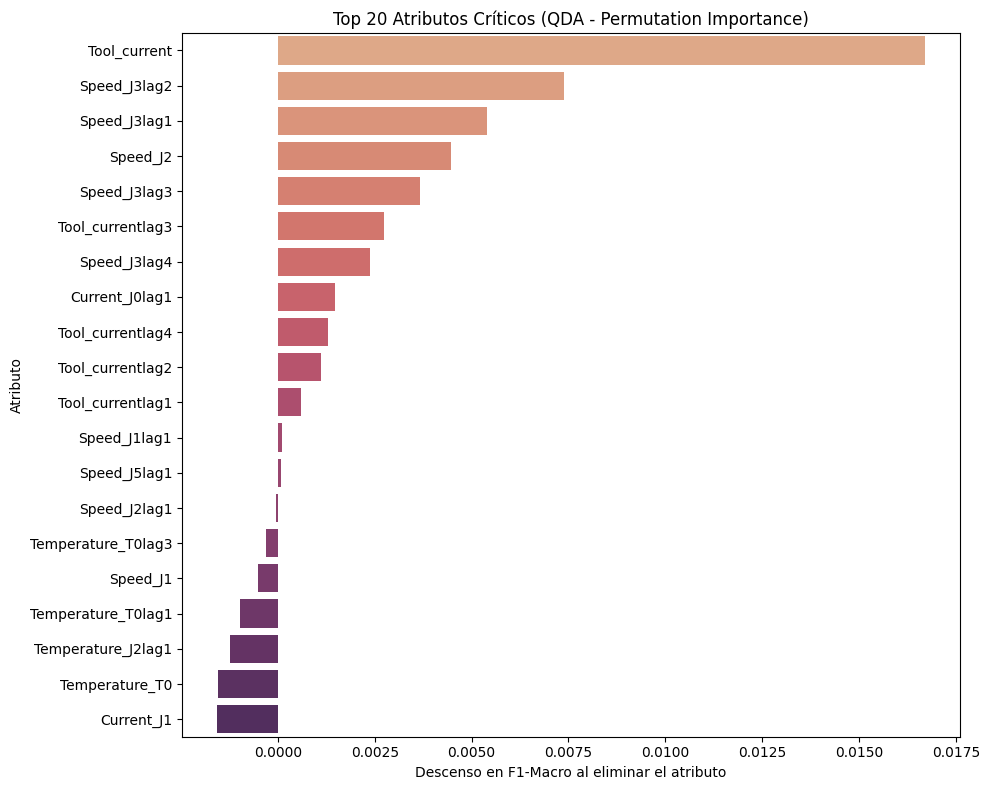


Top 5 atributos más críticos para QDA:
         Feature  Importance
18  Tool_current    0.016705
95  Speed_J3lag2    0.007379
94  Speed_J3lag1    0.005401
14      Speed_J2    0.004464
96  Speed_J3lag3    0.003658


In [ ]:
conf_matrix_qda = confusion_matrix(y_test, y_pred_qda, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_qda, annot=True, fmt='.2%', cmap='Oranges', 
            xticklabels=['OK (0)', 'Grip Lost (1)', 'Prot. Stop (2)'],
            yticklabels=['OK (0)', 'Grip Lost (1)', 'Prot. Stop (2)'])
plt.title('Matriz de Confusión Normalizada - QDA')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

print("Calculando importancia por permutación (ojo igual tarda)...")

# Calculamos la importancia
result = permutation_importance(
    best_qda, X_test_scaled, y_test, 
    n_repeats=10, random_state=42, n_jobs=-1, scoring='f1_macro'
)

# Extraemos los nombres de las columnas
feature_names = df_final.drop(columns=['Status_Combined', 'cycle']).columns

# Crear DataFrame con los resultados
qda_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': result.importances_mean,
    'Std': result.importances_std
}).sort_values(by='Importance', ascending=False)

# Graficar los 20 más importantes
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=qda_importance_df.head(20), palette='flare')
plt.title('Top 20 Atributos Críticos (QDA - Permutation Importance)')
plt.xlabel('Descenso en F1-Macro al eliminar el atributo')
plt.ylabel('Atributo')
plt.tight_layout()
plt.show()

# Mostrar el Top 5 por pantalla
print("\nTop 5 atributos más críticos para QDA:")
print(qda_importance_df[['Feature', 'Importance']].head(5))

### Modelos No Lineares

In [ ]:
import random
min_samples = pd.Series(y_train).value_counts().min()
k_neighbors_adj = min(5, min_samples - 1) # better safew than sorry 

print(f"\nAplicando SMOTE con k_neighbors={k_neighbors_adj} (Clase minoritaria tiene {min_samples} muestras)")

handler = ImbalanceHandler()
X_train_res, y_train_res = handler.smote_data(X_train_scaled, y_train, k_neighbors=k_neighbors_adj)

X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train_res, y_train_res, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_train_res
)

# Convertir a Tensores

X_train_t = torch.tensor(X_train_sub, dtype=torch.float32)
y_train_t = torch.tensor(y_train_sub, dtype=torch.long)
# Validation (para elegir el mejor)
X_val_t = torch.tensor(X_val, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.long)
# Test
X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)

print(f"Shapes -> Train: {X_train_t.shape}, Val: {X_val_t.shape}, Test: {X_test_t.shape}")

# DEFINICIÓN DEL MODELO DINÁMICO

class RobotClassifierDynamic(nn.Module):
    def __init__(self, input_dim, n_hidden_1, n_hidden_2, dropout_rate):
        super(RobotClassifierDynamic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, n_hidden_1),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(n_hidden_1, n_hidden_2),
            nn.ReLU(),
            nn.Linear(n_hidden_2, 3) # Salida: 3 clases
        )
        
    def forward(self, x):
        return self.model(x)

# RANDOM SEARCH

def train_and_evaluate(params, input_dim):
    # Configurar modelo con los params actuales
    model = RobotClassifierDynamic(
        input_dim, 
        n_hidden_1=params['hidden_1'],
        n_hidden_2=params['hidden_2'],
        dropout_rate=params['dropout']
    )
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=params['lr'])
    
    batch_size = params['batch_size']
    epochs = params['epochs']
    
    # Dataset y DataLoader para manejar batches
    train_ds = torch.utils.data.TensorDataset(X_train_t, y_train_t)
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    
    # Bucle de entrenamiento
    model.train()
    for epoch in range(epochs):
        for xb, yb in train_loader:
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
            
    # Evaluación en Validación
    model.eval()
    with torch.no_grad():
        logits_val = model(X_val_t)
        loss_val = criterion(logits_val, y_val_t).item()
        preds_val = torch.argmax(logits_val, dim=1)
        acc_val = (preds_val == y_val_t).float().mean().item()
        
    return acc_val, loss_val, model

# --- CONFIGURACIÓN DE LA BÚSQUEDA ---
NUM_TRIALS = 45 # Probaremos 45 combinaciones aleatorias
best_acc = 0.0
best_params = {}
best_model_state = None

# Espacio de búsqueda
param_dist = {
    'hidden_1': [32, 64, 128, 256],
    'hidden_2': [16, 32, 64],
    'dropout': [0.1, 0.2, 0.3, 0.5],
    'lr': [0.001, 0.0005, 0.0001],
    'batch_size': [16, 32, 64],
    'epochs': [30, 50] # Poquito para que no tarde un monton
}

print(f"\nIniciando Random Search de {NUM_TRIALS} iteraciones...")
print("-" * 60)

for i in range(NUM_TRIALS):
    # Samplear parámetros aleatorios
    current_params = {k: random.choice(v) for k, v in param_dist.items()}

    acc, loss, _ = train_and_evaluate(current_params, input_dim=X_train_t.shape[1])
    
    print(f"Iter {i+1}/{NUM_TRIALS} | Acc Val: {acc:.4f} | Loss Val: {loss:.4f} | Params: {current_params}")
    
    if acc > best_acc:
        best_acc = acc
        best_params = current_params

print("-" * 60)
print(f"MEJOR CONFIGURACIÓN ENCONTRADA (Acc: {best_acc:.4f}):")
print(best_params)

# ENTRENAMIENTO FINAL (TRAIN + VAL)
print("\nRe-entrenando modelo final con TODOS los datos de entrenamiento (Train+Val)...")

# Unimos Train_Sub + Val para aprovechar todos los datos
X_full_train = torch.cat((X_train_t, X_val_t), 0)
y_full_train = torch.cat((y_train_t, y_val_t), 0)

# 2. Instanciamos el modelo ganador
final_model = RobotClassifierDynamic(
    input_dim=X_full_train.shape[1],
    n_hidden_1=best_params['hidden_1'],
    n_hidden_2=best_params['hidden_2'],
    dropout_rate=best_params['dropout']
)

optimizer = optim.Adam(final_model.parameters(), lr=best_params['lr'])
criterion = nn.CrossEntropyLoss()

# DataLoader final
final_ds = torch.utils.data.TensorDataset(X_full_train, y_full_train)
final_loader = torch.utils.data.DataLoader(final_ds, batch_size=best_params['batch_size'], shuffle=True)

final_epochs = best_params['epochs'] + 10 

final_model.train()
for epoch in range(final_epochs):
    for xb, yb in final_loader:
        optimizer.zero_grad()
        outputs = final_model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

# EVALUACIÓN FINAL EN TEST SET

final_model.eval()
with torch.no_grad():
    logits_test = final_model(X_test_t)
    preds_test = torch.argmax(logits_test, dim=1)

print("\n--- REPORTE FINAL DE CLASIFICACIÓN (TEST SET) ---")
print(classification_report(y_test, preds_test.numpy()))


Aplicando SMOTE con k_neighbors=5 (Clase minoritaria tiene 140 muestras)
Shapes -> Train: torch.Size([9477, 114]), Val: torch.Size([2370, 114]), Test: torch.Size([1892, 114])

Iniciando Random Search de 45 iteraciones...
------------------------------------------------------------
Iter 1/45 | Acc Val: 0.9785 | Loss Val: 0.0753 | Params: {'hidden_1': 64, 'hidden_2': 16, 'dropout': 0.5, 'lr': 0.001, 'batch_size': 16, 'epochs': 30}
Iter 1/45 | Acc Val: 0.9785 | Loss Val: 0.0753 | Params: {'hidden_1': 64, 'hidden_2': 16, 'dropout': 0.5, 'lr': 0.001, 'batch_size': 16, 'epochs': 30}
Iter 2/45 | Acc Val: 0.9599 | Loss Val: 0.1151 | Params: {'hidden_1': 32, 'hidden_2': 64, 'dropout': 0.2, 'lr': 0.0001, 'batch_size': 32, 'epochs': 50}
Iter 2/45 | Acc Val: 0.9599 | Loss Val: 0.1151 | Params: {'hidden_1': 32, 'hidden_2': 64, 'dropout': 0.2, 'lr': 0.0001, 'batch_size': 32, 'epochs': 50}
Iter 3/45 | Acc Val: 0.9781 | Loss Val: 0.0719 | Params: {'hidden_1': 64, 'hidden_2': 64, 'dropout': 0.1, 'lr':

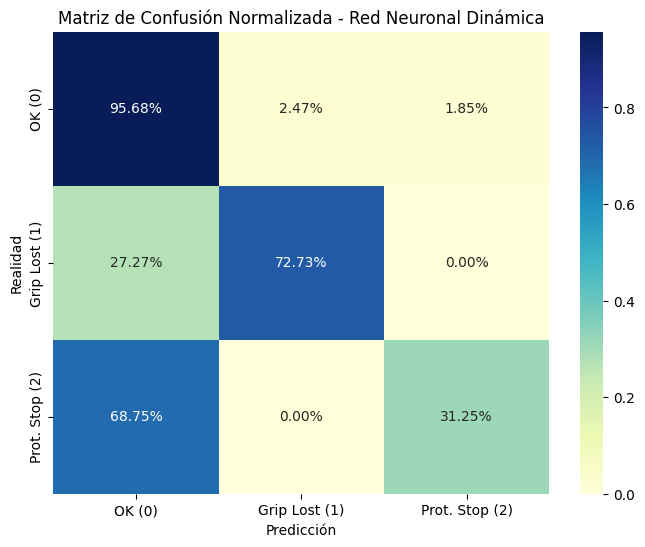

Calculando Permutation Importance para la Red Neuronal...


/tmp/ipykernel_157637/807507862.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=nn_importance_df.head(20), palette='plasma')


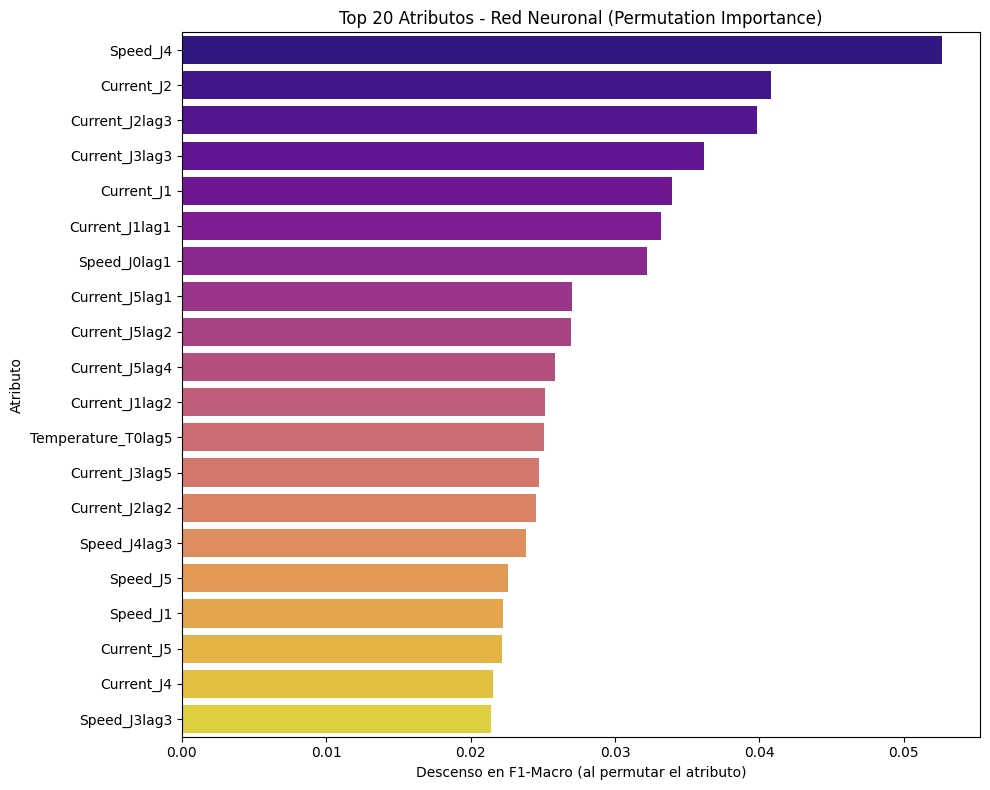


Top 5 atributos clave para la Red Neuronal:
           Feature  Importance
16        Speed_J4    0.052641
4       Current_J2    0.040829
41  Current_J2lag3    0.039836
51  Current_J3lag3    0.036155
2       Current_J1    0.033954


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score

# MATRIZ DE CONFUSIÓN (Red Neuronal)

conf_matrix_nn = confusion_matrix(y_test, preds_test.numpy(), normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_nn, annot=True, fmt='.2%', cmap='YlGnBu', 
            xticklabels=['OK (0)', 'Grip Lost (1)', 'Prot. Stop (2)'],
            yticklabels=['OK (0)', 'Grip Lost (1)', 'Prot. Stop (2)'])
plt.title('Matriz de Confusión Normalizada - Red Neuronal Dinámica')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

# IMPORTANCIA POR PERMUTACIÓN (PyTorch)
print("Calculando Permutation Importance para la Red Neuronal...")

def get_permutation_importance_pytorch(model, X_tensor, y_true, n_repeats=5):
    model.eval()
    baseline_preds = torch.argmax(model(X_tensor), dim=1).numpy()
    baseline_f1 = f1_score(y_true, baseline_preds, average='macro')

    importances = []
    feature_names = df_final.drop(columns=['Status_Combined', 'cycle']).columns

    for i in range(X_tensor.shape[1]):
        feature_scores = []
        for _ in range(n_repeats):
            X_permuted = X_tensor.clone()
            perm = torch.randperm(X_tensor.shape[0])
            X_permuted[:, i] = X_tensor[perm, i]

            with torch.no_grad():
                perm_preds = torch.argmax(model(X_permuted), dim=1).numpy()
                perm_f1 = f1_score(y_true, perm_preds, average='macro')

            feature_scores.append(baseline_f1 - perm_f1)

        importances.append(np.mean(feature_scores))

    return pd.DataFrame({'Feature': feature_names, 'Importance': importances})

nn_importance_df = get_permutation_importance_pytorch(final_model, X_test_t, y_test)
nn_importance_df = nn_importance_df.sort_values(by='Importance', ascending=False)

# Graficar los 20 más importantes
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=nn_importance_df.head(20), palette='plasma')
plt.title('Top 20 Atributos - Red Neuronal (Permutation Importance)')
plt.xlabel('Descenso en F1-Macro (al permutar el atributo)')
plt.ylabel('Atributo')
plt.tight_layout()
plt.show()

print("\nTop 5 atributos clave para la Red Neuronal:")
print(nn_importance_df.head(5))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report

# 1. Configuración de la Grilla de Parámetros
param_grid_rf = {
    'n_estimators': [3, 5, 10, 30, 100, 200, 300],
    'max_depth': [1, 3, 5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced', 'balanced_subsample']
}


# 3. Inicialización del GridSearch
grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid_rf,
    cv=StratifiedGroupKFold(n_splits=5),
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

# 4. Entrenamiento
print("Buscando mejores parámetros para Random Forest...")
grid_rf.fit(X_train_scaled, y_train, groups=groups_train)

# 5. Reporte de Resultados
best_rf = grid_rf.best_estimator_
print(f"\n--- MEJOR MODELO ENCONTRADO: Random Forest ---")
print(f"Mejores Parámetros: {grid_rf.best_params_}")

# Predicción y Evaluación
y_pred_rf = best_rf.predict(X_test_scaled)
print("\nReporte de Clasificación Final (Test Set):")
print(classification_report(y_test, y_pred_rf))

Buscando mejores parámetros para Random Forest...
Fitting 5 folds for each of 252 candidates, totalling 1260 fits

--- MEJOR MODELO ENCONTRADO: Random Forest ---
Mejores Parámetros: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 5}

Reporte de Clasificación Final (Test Set):
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95      1784
         1.0       0.23      0.39      0.29        44
         2.0       0.32      0.55      0.41        64

    accuracy                           0.90      1892
   macro avg       0.51      0.62      0.55      1892
weighted avg       0.93      0.90      0.91      1892


--- MEJOR MODELO ENCONTRADO: Random Forest ---
Mejores Parámetros: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 5}

Reporte de Clasificación Final (Test Set):
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95     

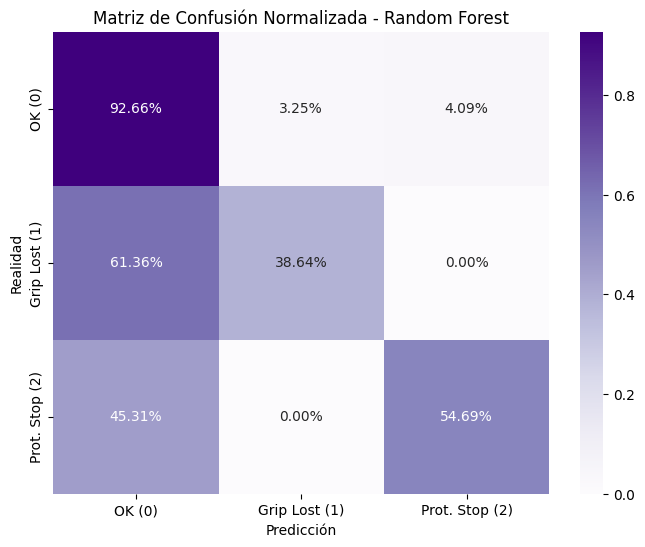

/tmp/ipykernel_157637/3033735943.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=rf_importance_df.head(20), palette='viridis')


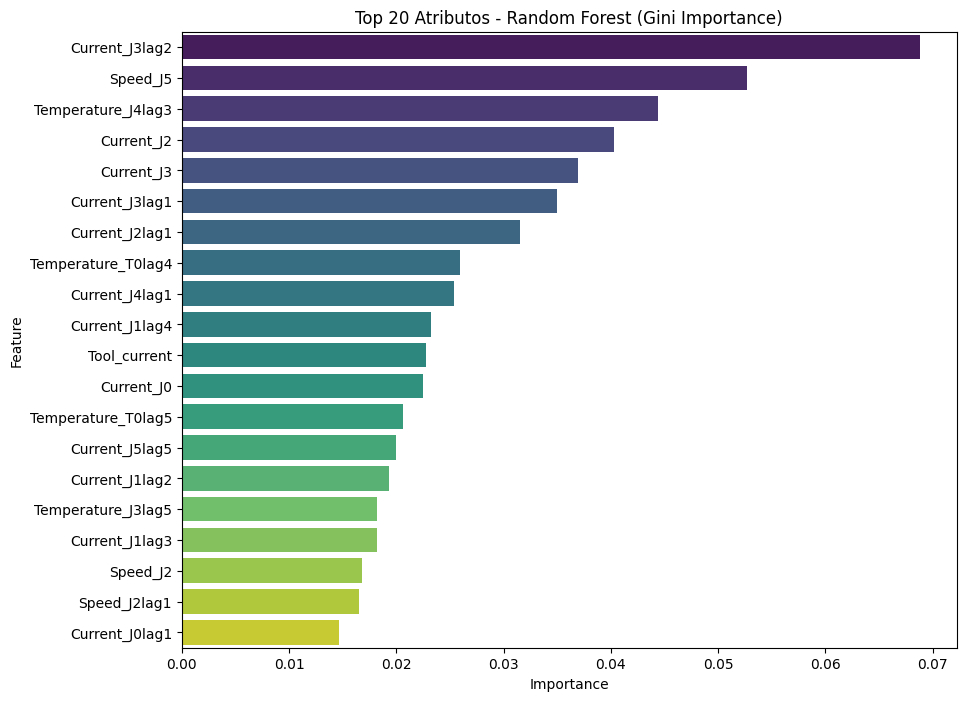

Calculando Permutation Importance (esto puede tardar un poco más en RF)...


/tmp/ipykernel_157637/3033735943.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=rf_perm_importance_df.head(20), palette='magma')


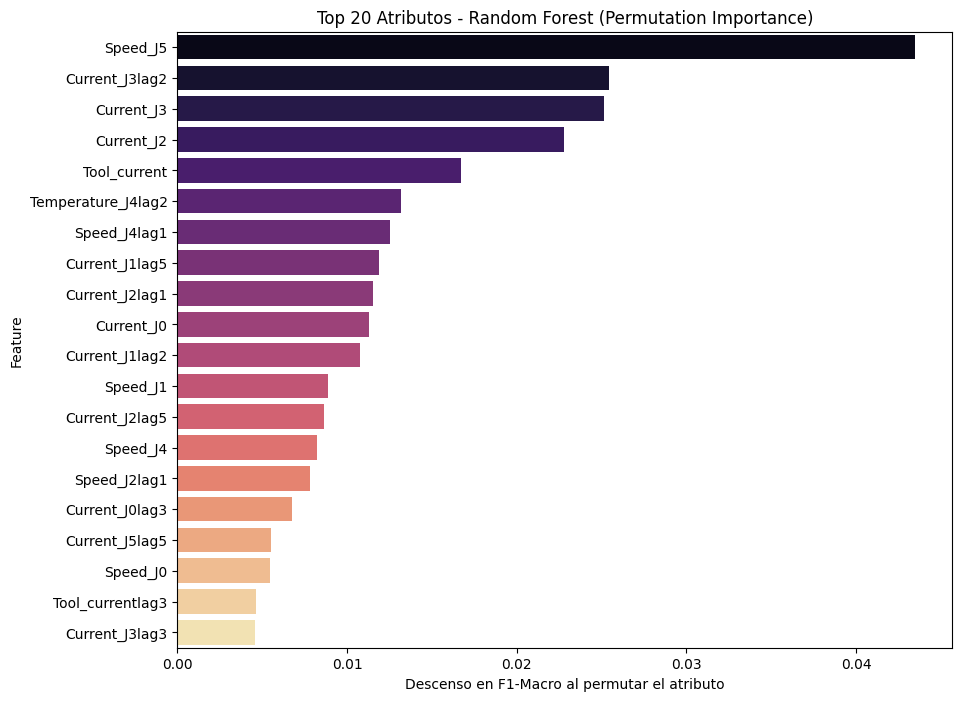

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance

# 1. MATRIZ DE CONFUSIÓN
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='.2%', cmap='Purples', 
            xticklabels=['OK (0)', 'Grip Lost (1)', 'Prot. Stop (2)'],
            yticklabels=['OK (0)', 'Grip Lost (1)', 'Prot. Stop (2)'])
plt.title('Matriz de Confusión Normalizada - Random Forest')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

# Extraemos nombres de columnas
feature_names = df_final.drop(columns=['Status_Combined', 'cycle']).columns

# 2. IMPORTANCIA (Gini)
rf_importances = best_rf.feature_importances_
rf_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=rf_importance_df.head(20), palette='viridis')
plt.title('Top 20 Atributos - Random Forest (Gini Importance)')
plt.show()

# 3. IMPORTANCIA POR PERMUTACIÓN
print("Calculando Permutation Importance...")
result_rf = permutation_importance(
    best_rf, X_test_scaled, y_test, 
    n_repeats=5, random_state=42, n_jobs=-1, scoring='f1_macro'
)

rf_perm_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': result_rf.importances_mean,
    'Std': result_rf.importances_std
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=rf_perm_importance_df.head(20), palette='magma')
plt.title('Top 20 Atributos - Random Forest (Permutation Importance)')
plt.xlabel('Descenso en F1-Macro al permutar el atributo')
plt.show()

In [ ]:
from sklearn.svm import SVC

# 1. Configuración de la Grilla
param_grid_rbf = {
    'C': [0.1, 1, 10, 100],        
    'gamma': ['scale', 'auto', 0.1],  
    'class_weight': ['balanced']
}

# 2. Inicialización
grid_rbf = GridSearchCV(
    SVC(kernel='rbf', cache_size=1000), # cache_size pa que vaya rapoido
    param_grid_rbf,
    cv=StratifiedGroupKFold(n_splits=5),
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

# 3. Entrenamiento
print("Entrenando SVM con Kernel RBF...")
grid_rbf.fit(X_train_scaled, y_train, groups=groups_train)

# 4. Resultados
best_rbf = grid_rbf.best_estimator_
print(f"\n--- MEJOR MODELO SVM-RBF ---")
print(f"Mejores Parámetros: {grid_rbf.best_params_}")

# Predicción
y_pred_rbf = best_rbf.predict(X_test_scaled)
print("\nReporte de Clasificación (SVM-RBF):")
print(classification_report(y_test, y_pred_rbf))

Entrenando SVM con Kernel RBF (Esto puede tardar)...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

--- MEJOR MODELO SVM-RBF ---
Mejores Parámetros: {'C': 100, 'class_weight': 'balanced', 'gamma': 'auto'}

Reporte de Clasificación (SVM-RBF):
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.96      1784
         1.0       0.28      0.59      0.38        44
         2.0       0.49      0.30      0.37        64

    accuracy                           0.92      1892
   macro avg       0.58      0.61      0.57      1892
weighted avg       0.93      0.92      0.92      1892


--- MEJOR MODELO SVM-RBF ---
Mejores Parámetros: {'C': 100, 'class_weight': 'balanced', 'gamma': 'auto'}

Reporte de Clasificación (SVM-RBF):
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.96      1784
         1.0       0.28      0.59      0.38        44
         2.0       0.49      0.30      0.37        64

 

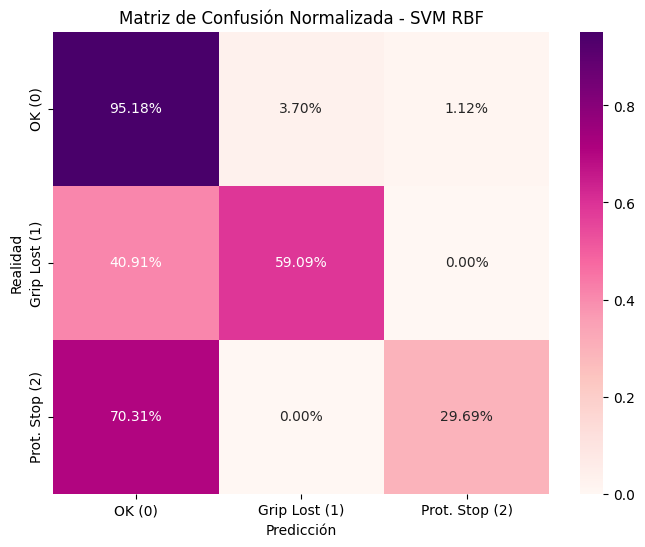

Calculando Permutation Importance para SVM RBF (esto puede tardar un poco)...


/tmp/ipykernel_157637/2098267886.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=rbf_importance_df.head(20), palette='coolwarm')


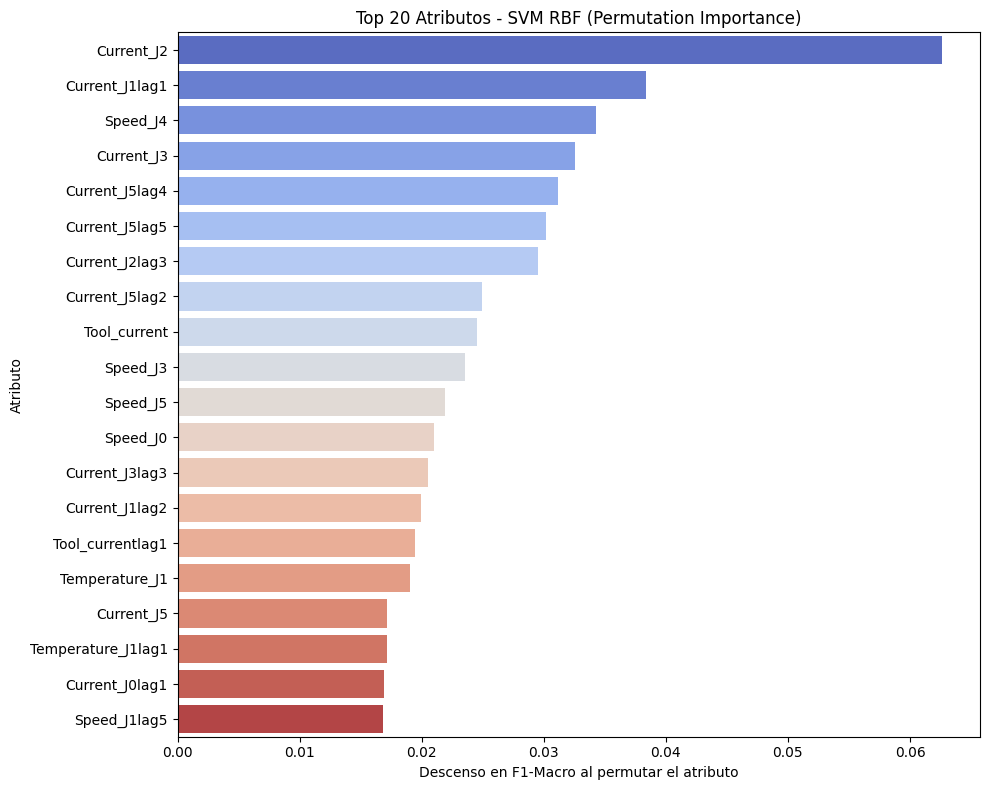


Top 5 atributos más críticos para SVM RBF:
           Feature  Importance
4       Current_J2    0.062603
29  Current_J1lag1    0.038372
16        Speed_J4    0.034312
6       Current_J3    0.032597
72  Current_J5lag4    0.031127


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance

# 1. MATRIZ DE CONFUSIÓN (SVM RBF)
conf_matrix_rbf = confusion_matrix(y_test, y_pred_rbf, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rbf, annot=True, fmt='.2%', cmap='RdPu', 
            xticklabels=['OK (0)', 'Grip Lost (1)', 'Prot. Stop (2)'],
            yticklabels=['OK (0)', 'Grip Lost (1)', 'Prot. Stop (2)'])
plt.title('Matriz de Confusión Normalizada - SVM RBF')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

# 2. IMPORTANCIA POR PERMUTACIÓN (SVM RBF)
print("Calculando Permutation Importance para SVM RBF...")

result_rbf = permutation_importance(
    best_rbf, X_test_scaled, y_test, 
    n_repeats=5, random_state=42, n_jobs=-1, scoring='f1_macro'
)

# Extraemos los nombres de las columnas
feature_names = df_final.drop(columns=['Status_Combined', 'cycle']).columns

# Crear DataFrame con los resultados
rbf_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': result_rbf.importances_mean,
    'Std': result_rbf.importances_std
}).sort_values(by='Importance', ascending=False)

# Graficar los 20 más importantes
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=rbf_importance_df.head(20), palette='coolwarm')
plt.title('Top 20 Atributos - SVM RBF (Permutation Importance)')
plt.xlabel('Descenso en F1-Macro al permutar el atributo')
plt.ylabel('Atributo')
plt.tight_layout()
plt.show()

# Mostrar el Top 5 por pantalla
print("\nTop 5 atributos más críticos para SVM RBF:")
print(rbf_importance_df[['Feature', 'Importance']].head(5))

## Combinacion

--- INICIANDO BÚSQUEDA DE STACKING EXTENDIDA (8 configs) ---
Probando: Base=[RF+SVC_RBF+QDA+NeuralNet] -> Meta=[LogisticRegression] ... 

/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


F1: 0.4699
Probando: Base=[RF+SVC_RBF+QDA+NeuralNet] -> Meta=[RandomForest] ... 

/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


F1: 0.4811
Probando: Base=[RF+Logistic+LinearSVC] -> Meta=[LogisticRegression] ... F1: 0.4373
Probando: Base=[RF+Logistic+LinearSVC] -> Meta=[RandomForest] ... F1: 0.4373
Probando: Base=[RF+Logistic+LinearSVC] -> Meta=[RandomForest] ... F1: 0.4730
Probando: Base=[RF+NeuralNet+SVC_RBF] -> Meta=[LogisticRegression] ... F1: 0.4730
Probando: Base=[RF+NeuralNet+SVC_RBF] -> Meta=[LogisticRegression] ... F1: 0.4959
Probando: Base=[RF+NeuralNet+SVC_RBF] -> Meta=[RandomForest] ... F1: 0.4959
Probando: Base=[RF+NeuralNet+SVC_RBF] -> Meta=[RandomForest] ... F1: 0.4777
Probando: Base=[Logistic+RF+QDA] -> Meta=[LogisticRegression] ... F1: 0.4777
Probando: Base=[Logistic+RF+QDA] -> Meta=[LogisticRegression] ... 

/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


F1: 0.4054
Probando: Base=[Logistic+RF+QDA] -> Meta=[RandomForest] ... 

/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


F1: 0.4713

MEJOR STACKING ENCONTRADO: Base=[RF+NeuralNet+SVC_RBF] -> Meta=[LogisticRegression]
F1-Macro final (Test Set): 0.4959


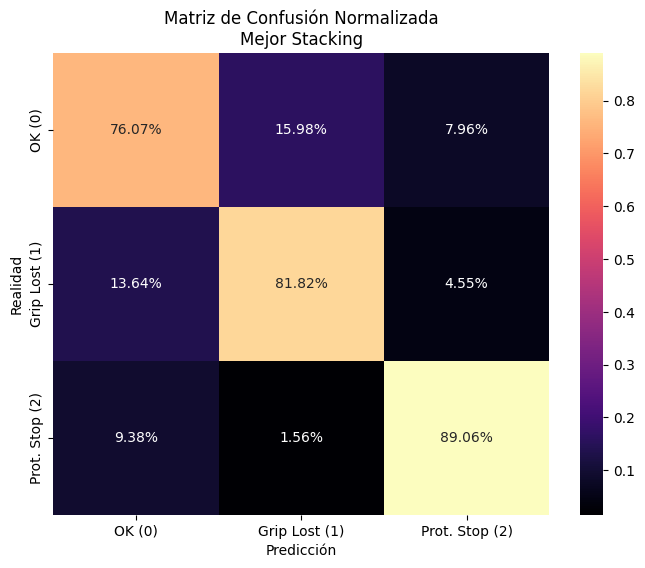


--- REPORTE FINAL STACKING ---
              precision    recall  f1-score   support

         0.0       0.99      0.76      0.86      1784
         1.0       0.11      0.82      0.20        44
         2.0       0.28      0.89      0.43        64

    accuracy                           0.77      1892
   macro avg       0.46      0.82      0.50      1892
weighted avg       0.95      0.77      0.83      1892



In [ ]:
# from sklearn.ensemble import StackingClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import LinearSVC
# from sklearn.metrics import f1_score
# from sklearn.base import BaseEstimator, ClassifierMixin

# # ==========================================
# # 0. WRAPPER PARA RED NEURONAL (Compatible con Sklearn)
# # ==========================================
# # Necesario para que StackingClassifier pueda re-entrenar la red en cada fold
# class PyTorchWrapper(BaseEstimator, ClassifierMixin):
#     def __init__(self, input_dim, hidden_1=64, hidden_2=32, dropout=0.2, lr=0.001, epochs=50, batch_size=32):
#         self.input_dim = input_dim
#         self.hidden_1 = hidden_1
#         self.hidden_2 = hidden_2
#         self.dropout = dropout
#         self.lr = lr
#         self.epochs = epochs
#         self.batch_size = batch_size
#         self.model = None
#         self.classes_ = [0, 1, 2] # Definimos las clases fijas
        
#     def fit(self, X, y):
#         # Instanciamos una nueva red limpia
#         self.model = RobotClassifierDynamic(self.input_dim, self.hidden_1, self.hidden_2, self.dropout)
#         criterion = nn.CrossEntropyLoss()
#         optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        
#         # Convertimos a tensores
#         X_t = torch.tensor(X, dtype=torch.float32)
#         # Aseguramos que y sea numpy
#         y_np = y.to_numpy() if isinstance(y, pd.Series) else y
#         y_t = torch.tensor(y_np, dtype=torch.long)
        
#         ds = torch.utils.data.TensorDataset(X_t, y_t)
#         loader = torch.utils.data.DataLoader(ds, batch_size=self.batch_size, shuffle=True)
        
#         self.model.train()
#         for epoch in range(self.epochs):
#             for xb, yb in loader:
#                 optimizer.zero_grad()
#                 outputs = self.model(xb)
#                 loss = criterion(outputs, yb)
#                 loss.backward()
#                 optimizer.step()
#         return self
    
#     def predict(self, X):
#         self.model.eval()
#         with torch.no_grad():
#             X_t = torch.tensor(X, dtype=torch.float32)
#             logits = self.model(X_t)
#             return torch.argmax(logits, dim=1).numpy()

#     def predict_proba(self, X):
#         self.model.eval()
#         with torch.no_grad():
#             X_t = torch.tensor(X, dtype=torch.float32)
#             logits = self.model(X_t)
#             return torch.softmax(logits, dim=1).numpy()

# # ==========================================
# # 1. PREPARACIÓN DE ESTIMADORES
# # ==========================================

# # A. Instanciar wrapper de NN con los mejores params encontrados
# nn_estimator = PyTorchWrapper(
#     input_dim=X_train_scaled.shape[1],
#     **best_params # Usamos los params del Random Search anterior
# )

# # B. Asegurar que SVC tenga probabilidad habilitada para el stacking (mejora rendimiento)
# best_rbf.probability = True 

# # C. Definir Pool Completo (Ahora incluimos Logistic y NN)
# estimators_pool = {
#     'RF': best_rf,
#     'SVC_RBF': best_rbf,
#     'QDA': best_qda,
#     'LinearSVC': grid_svm.best_estimator_,
#     'Logistic': best_log, # <--- Agregado
#     'NeuralNet': nn_estimator # <--- Agregado
# }

# # 2. DEFINIR COMBINACIONES A PROBAR
# # Aumentamos la diversidad de combinaciones
# base_combinations = [
#     # "All stars" (Todos los tipos)
#     [('RF', estimators_pool['RF']), ('SVC_RBF', estimators_pool['SVC_RBF']), ('QDA', estimators_pool['QDA']), ('NeuralNet', estimators_pool['NeuralNet'])],
    
#     # "Fast & Robust" (Sin NN ni SVC pesado)
#     [('RF', estimators_pool['RF']), ('Logistic', estimators_pool['Logistic']), ('LinearSVC', estimators_pool['LinearSVC'])],
    
#     # "Non-Linear Deep" (RF + NN + RBF)
#     [('RF', estimators_pool['RF']), ('NeuralNet', estimators_pool['NeuralNet']), ('SVC_RBF', estimators_pool['SVC_RBF'])],
    
#     # Clásica + QDA
#     [('Logistic', estimators_pool['Logistic']), ('RF', estimators_pool['RF']), ('QDA', estimators_pool['QDA'])]
# ]

# # 3. DEFINIR META-MODELOS
# final_estimators = [
#     ('LogisticRegression', LogisticRegression(class_weight='balanced')), 
#     ('RandomForest', RandomForestClassifier(n_estimators=50, max_depth=5, class_weight='balanced')) # A veces un RF simplificado va mejor de meta
# ]

# # 4. LOOP DE STACKING
# sgkf = StratifiedGroupKFold(n_splits=5)
# # Generamos splits (usando groups_train para respetar ciclos)
# cv_indices = list(sgkf.split(X_train_scaled, y_train, groups=groups_train))

# best_stack_score = -1
# best_stack_model = None
# best_stack_desc = ""

# print(f"--- INICIANDO BÚSQUEDA DE STACKING EXTENDIDA ({len(base_combinations) * len(final_estimators)} configs) ---")

# for base_est_list in base_combinations:
#     base_names = "+".join([name for name, _ in base_est_list])
    
#     for final_name, final_est in final_estimators:
#         print(f"Probando: Base=[{base_names}] -> Meta=[{final_name}] ... ", end="")
        
#         try:
#             stack = StackingClassifier(
#                 estimators=base_est_list,
#                 final_estimator=final_est,
#                 cv=cv_indices,
#                 n_jobs=-1, # Ojo con NN y multiprocessing, a veces falla. Si falla, poner n_jobs=1
#                 passthrough=False 
#             )
            
#             # Entrenar (Si falla por joblib con torch, cambiar n_jobs a None)
#             try:
#                 stack.fit(X_train_scaled, y_train)
#             except:
#                 print("(Reintentando con n_jobs=1 por compatibilidad Torch) ...", end="")
#                 stack.n_jobs = None
#                 stack.fit(X_train_scaled, y_train)
            
#             # Evaluar
#             y_pred_s = stack.predict(X_test_scaled)
#             score = f1_score(y_test, y_pred_s, average='macro')
            
#             print(f"F1: {score:.4f}")
            
#             if score > best_stack_score:
#                 best_stack_score = score
#                 best_stack_model = stack
#                 best_stack_desc = f"Base=[{base_names}] -> Meta=[{final_name}]"
                
#         except Exception as e:
#             print(f"ERROR: {e}")

# # ==========================================
# # 5. RESULTADOS FINALES
# # ==========================================
# print("\n" + "="*60)
# print(f"MEJOR STACKING ENCONTRADO: {best_stack_desc}")
# print(f"F1-Macro final (Test Set): {best_stack_score:.4f}")
# print("="*60)

# # Matriz de Confusión
# plt.figure(figsize=(8, 6))
# y_pred_best = best_stack_model.predict(X_test_scaled)
# conf_matrix_stack = confusion_matrix(y_test, y_pred_best, normalize='true')

# sns.heatmap(conf_matrix_stack, annot=True, fmt='.2%', cmap='magma', 
#             xticklabels=['OK (0)', 'Grip Lost (1)', 'Prot. Stop (2)'],
#             yticklabels=['OK (0)', 'Grip Lost (1)', 'Prot. Stop (2)'])
# plt.title(f'Matriz de Confusión Normalizada\nMejor Stacking')
# plt.xlabel('Predicción')
# plt.ylabel('Realidad')
# plt.show()

# print("\n--- REPORTE FINAL STACKING ---")
# print(classification_report(y_test, y_pred_best))

--- INICIANDO BÚSQUEDA OPTIMIZADA (12 configs) ---
Probando: Base=[RF+Logistic] -> Meta=[LogisticRegression] ... F1: 0.4138
Probando: Base=[RF+Logistic] -> Meta=[RandomForest] ... F1: 0.4138
Probando: Base=[RF+Logistic] -> Meta=[RandomForest] ... F1: 0.4661
Probando: Base=[RF+QDA] -> Meta=[LogisticRegression] ... F1: 0.4661
Probando: Base=[RF+QDA] -> Meta=[LogisticRegression] ... 

/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


F1: 0.3987
Probando: Base=[RF+QDA] -> Meta=[RandomForest] ... 

/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


F1: 0.4550
Probando: Base=[RF+NeuralNet] -> Meta=[LogisticRegression] ... F1: 0.4666
Probando: Base=[RF+NeuralNet] -> Meta=[RandomForest] ... F1: 0.4666
Probando: Base=[RF+NeuralNet] -> Meta=[RandomForest] ... F1: 0.4787
Probando: Base=[RF+Logistic+QDA] -> Meta=[LogisticRegression] ... F1: 0.4787
Probando: Base=[RF+Logistic+QDA] -> Meta=[LogisticRegression] ... 

/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


F1: 0.4056
Probando: Base=[RF+Logistic+QDA] -> Meta=[RandomForest] ... 

/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


F1: 0.4727
Probando: Base=[RF+NeuralNet+LinearSVC] -> Meta=[LogisticRegression] ... F1: 0.4729
Probando: Base=[RF+NeuralNet+LinearSVC] -> Meta=[RandomForest] ... F1: 0.4729
Probando: Base=[RF+NeuralNet+LinearSVC] -> Meta=[RandomForest] ... F1: 0.4809
Probando: Base=[RF+SVC_RBF+Logistic] -> Meta=[LogisticRegression] ... F1: 0.4809
Probando: Base=[RF+SVC_RBF+Logistic] -> Meta=[LogisticRegression] ... F1: 0.4592
Probando: Base=[RF+SVC_RBF+Logistic] -> Meta=[RandomForest] ... F1: 0.4592
Probando: Base=[RF+SVC_RBF+Logistic] -> Meta=[RandomForest] ... F1: 0.4946

MEJOR STACKING ENCONTRADO: Base=[RF+SVC_RBF+Logistic] -> Meta=[RandomForest]
F1-Macro final (Test Set): 0.4946
F1: 0.4946

MEJOR STACKING ENCONTRADO: Base=[RF+SVC_RBF+Logistic] -> Meta=[RandomForest]
F1-Macro final (Test Set): 0.4946


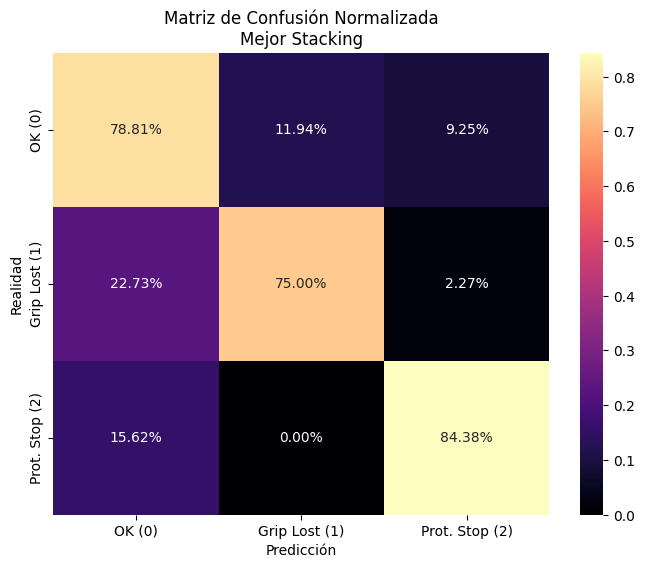


--- REPORTE FINAL STACKING ---
              precision    recall  f1-score   support

         0.0       0.99      0.79      0.88      1784
         1.0       0.13      0.75      0.23        44
         2.0       0.25      0.84      0.38        64

    accuracy                           0.79      1892
   macro avg       0.46      0.79      0.49      1892
weighted avg       0.94      0.79      0.84      1892



In [ ]:
# from sklearn.ensemble import StackingClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import LinearSVC
# from sklearn.metrics import f1_score
# from sklearn.base import BaseEstimator, ClassifierMixin
# import itertools

# # ==========================================
# # 0. WRAPPER PARA RED NEURONAL (Compatible con Sklearn)
# # ==========================================
# class PyTorchWrapper(BaseEstimator, ClassifierMixin):
#     def __init__(self, input_dim, hidden_1=64, hidden_2=32, dropout=0.2, lr=0.001, epochs=50, batch_size=32):
#         self.input_dim = input_dim
#         self.hidden_1 = hidden_1
#         self.hidden_2 = hidden_2
#         self.dropout = dropout
#         self.lr = lr
#         self.epochs = epochs
#         self.batch_size = batch_size
#         self.model = None
#         self.classes_ = [0, 1, 2] 
        
#     def fit(self, X, y):
#         self.model = RobotClassifierDynamic(self.input_dim, self.hidden_1, self.hidden_2, self.dropout)
#         criterion = nn.CrossEntropyLoss()
#         optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        
#         X_t = torch.tensor(X, dtype=torch.float32)
#         y_np = y.to_numpy() if isinstance(y, pd.Series) else y
#         y_t = torch.tensor(y_np, dtype=torch.long)
        
#         ds = torch.utils.data.TensorDataset(X_t, y_t)
#         loader = torch.utils.data.DataLoader(ds, batch_size=self.batch_size, shuffle=True)
        
#         self.model.train()
#         for epoch in range(self.epochs):
#             for xb, yb in loader:
#                 optimizer.zero_grad()
#                 outputs = self.model(xb)
#                 loss = criterion(outputs, yb)
#                 loss.backward()
#                 optimizer.step()
#         return self
    
#     def predict(self, X):
#         self.model.eval()
#         with torch.no_grad():
#             X_t = torch.tensor(X, dtype=torch.float32)
#             logits = self.model(X_t)
#             return torch.argmax(logits, dim=1).numpy()

#     def predict_proba(self, X):
#         self.model.eval()
#         with torch.no_grad():
#             X_t = torch.tensor(X, dtype=torch.float32)
#             logits = self.model(X_t)
#             return torch.softmax(logits, dim=1).numpy()

# # ==========================================
# # 1. PREPARACIÓN DE ESTIMADORES
# # ==========================================

# # A. Instanciar wrapper de NN
# nn_estimator = PyTorchWrapper(
#     input_dim=X_train_scaled.shape[1],
#     **best_params 
# )

# # B. Asegurar probabilidad en SVM
# best_rbf.probability = True 

# # C. Definir Pool
# estimators_pool = {
#     'RF': best_rf,
#     'SVC_RBF': best_rbf,    # OJO: Este es el más lento
#     'QDA': best_qda,
#     'LinearSVC': grid_svm.best_estimator_,
#     'Logistic': best_log, 
#     'NeuralNet': nn_estimator 
# }

# # ==========================================
# # 2. DEFINIR COMBINACIONES (ESTRATEGIA RÁPIDA)
# # ==========================================
# # En lugar de itertools.combinations (que generaría 35 combinaciones y tardaría horas),
# # seleccionamos manualmente las mezclas más potentes de 2 y 3 modelos.

# base_combinations = [
#     # --- PAREJAS (Rápidas y Diversas) ---
#     # 1. El estándar robusto: Árbol + Lineal
#     [('RF', estimators_pool['RF']), ('Logistic', estimators_pool['Logistic'])],
    
#     # 2. La mezcla estadística: Generativo (QDA) + Árbol
#     [('RF', estimators_pool['RF']), ('QDA', estimators_pool['QDA'])],
    
#     # 3. Potencia pura: Red Neuronal + Árbol (Puede tardar un poco más)
#     [('RF', estimators_pool['RF']), ('NeuralNet', estimators_pool['NeuralNet'])],

#     # --- TRÍOS (Balanceados) ---
#     # 4. El trío rápido: Los 3 más veloces
#     [('RF', estimators_pool['RF']), ('Logistic', estimators_pool['Logistic']), ('QDA', estimators_pool['QDA'])],
    
#     # 5. El trío de alto rendimiento (Sin RBF para no eternizar)
#     [('RF', estimators_pool['RF']), ('NeuralNet', estimators_pool['NeuralNet']), ('LinearSVC', estimators_pool['LinearSVC'])],
    
#     # 6. La apuesta completa (Solo una con RBF porque es muy lento)
#     [('RF', estimators_pool['RF']), ('SVC_RBF', estimators_pool['SVC_RBF']), ('Logistic', estimators_pool['Logistic'])]
# ]

# # 3. DEFINIR META-MODELOS
# # Reducimos a uno solo si quieres ir rápido, o dejamos los dos clásicos
# final_estimators = [
#     ('LogisticRegression', LogisticRegression(class_weight='balanced')), 
#     # Comentamos RF como meta-modelo temporalmente si quieres más velocidad, 
#     # pero suele ir bien. Lo dejo activado.
#     ('RandomForest', RandomForestClassifier(n_estimators=50, max_depth=5, class_weight='balanced')) 
# ]

# # 4. LOOP DE STACKING
# sgkf = StratifiedGroupKFold(n_splits=5)
# cv_indices = list(sgkf.split(X_train_scaled, y_train, groups=groups_train))

# best_stack_score = -1
# best_stack_model = None
# best_stack_desc = ""

# print(f"--- INICIANDO BÚSQUEDA OPTIMIZADA ({len(base_combinations) * len(final_estimators)} configs) ---")

# for base_est_list in base_combinations:
#     base_names = "+".join([name for name, _ in base_est_list])
    
#     for final_name, final_est in final_estimators:
#         print(f"Probando: Base=[{base_names}] -> Meta=[{final_name}] ... ", end="")
        
#         try:
#             stack = StackingClassifier(
#                 estimators=base_est_list,
#                 final_estimator=final_est,
#                 cv=cv_indices,
#                 n_jobs=1, # FORZAMOS 1 PARA EVITAR ERRORES DE JOBLIB/TORCH Y REINICIOS
#                 passthrough=False 
#             )
            
#             # Entrenar
#             stack.fit(X_train_scaled, y_train)
            
#             # Evaluar
#             y_pred_s = stack.predict(X_test_scaled)
#             score = f1_score(y_test, y_pred_s, average='macro')
            
#             print(f"F1: {score:.4f}")
            
#             if score > best_stack_score:
#                 best_stack_score = score
#                 best_stack_model = stack
#                 best_stack_desc = f"Base=[{base_names}] -> Meta=[{final_name}]"
                
#         except Exception as e:
#             print(f"ERROR: {e}")

# # ==========================================
# # 5. RESULTADOS FINALES
# # ==========================================
# print("\n" + "="*60)
# print(f"MEJOR STACKING ENCONTRADO: {best_stack_desc}")
# print(f"F1-Macro final (Test Set): {best_stack_score:.4f}")
# print("="*60)

# # Matriz de Confusión
# plt.figure(figsize=(8, 6))
# y_pred_best = best_stack_model.predict(X_test_scaled)
# conf_matrix_stack = confusion_matrix(y_test, y_pred_best, normalize='true')

# sns.heatmap(conf_matrix_stack, annot=True, fmt='.2%', cmap='magma', 
#             xticklabels=['OK (0)', 'Grip Lost (1)', 'Prot. Stop (2)'],
#             yticklabels=['OK (0)', 'Grip Lost (1)', 'Prot. Stop (2)'])
# plt.title(f'Matriz de Confusión Normalizada\nMejor Stacking')
# plt.xlabel('Predicción')
# plt.ylabel('Realidad')
# plt.show()

# print("\n--- REPORTE FINAL STACKING ---")
# print(classification_report(y_test, y_pred_best))

In [ ]:
 
# from sklearn.ensemble import StackingClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import StratifiedGroupKFold


# sgkf = StratifiedGroupKFold(n_splits=5)
# # Generamos los índices de entrenamiento/validación de antemano usando los grupos
# cv_indices = list(sgkf.split(X_train_scaled, y_train, groups=groups_train))

# # 2. Definir los estimadores base (asegúrate de que estén definidos de tus pasos anteriores)
# estimators = [
#     ('rf', best_rf),
#     ('svc_rbf', best_rbf),
#     ('log_reg', best_log),
#     ('qda', best_qda)
# ]

# # 3. Configurar el Stacking pasando los índices ya calculados
# stack_model = StackingClassifier(
#     estimators=estimators,
#     final_estimator=LogisticRegression(),
#     cv=cv_indices,  # <--- Pasamos los índices aquí
#     n_jobs=-1,
#     passthrough=False
# )

# # 4. Entrenar (Ahora ya NO pasamos groups=groups_train aquí)
# print("Entrenando el StackingClassifier con splits pre-calculados por ciclo...")
# stack_model.fit(X_train_scaled, y_train)

# # 5. Evaluación final
# y_pred_stack = stack_model.predict(X_test_scaled)

# print("\n--- REPORTE FINAL: STACKING ENSEMBLE ---")
# print(classification_report(y_test, y_pred_stack))

Entrenando el StackingClassifier con splits pre-calculados por ciclo...


/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")



--- REPORTE FINAL: STACKING ENSEMBLE ---
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97      1784
         1.0       0.63      0.39      0.48        44
         2.0       0.43      0.19      0.26        64

    accuracy                           0.94      1892
   macro avg       0.67      0.52      0.57      1892
weighted avg       0.93      0.94      0.94      1892



--- INICIANDO STACKING (6 combinaciones) ---

> Entrenando Stack: [RF + Logistic] ...
  --> F1-Macro: 0.4140

> Entrenando Stack: [RF + LinearSVC] ...
  --> F1-Macro: 0.4140

> Entrenando Stack: [RF + LinearSVC] ...
  --> F1-Macro: 0.4358

> Entrenando Stack: [RF + QDA] ...
  --> F1-Macro: 0.4358

> Entrenando Stack: [RF + QDA] ...


/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


  --> F1-Macro: 0.3987

> Entrenando Stack: [RF + RBF + Logistic] ...
  --> F1-Macro: 0.4600

> Entrenando Stack: [RF + NN + LinearSVC] ...
  --> F1-Macro: 0.4600

> Entrenando Stack: [RF + NN + LinearSVC] ...
  --> F1-Macro: 0.4688

> Entrenando Stack: [RF + RBF + QDA + NN] ...
  --> F1-Macro: 0.4688

> Entrenando Stack: [RF + RBF + QDA + NN] ...


/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/adria/UPC/7e_quatri/APA/APA_FINAL/.venv/lib/python3.11/site-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


  --> F1-Macro: 0.4719

MEJOR COMBINACIÓN: RF + RBF + QDA + NN
F1-Macro: 0.4946

Ranking de Combinaciones:
                Modelo        F1
5  RF + RBF + QDA + NN  0.471877
4  RF + NN + LinearSVC  0.468787
3  RF + RBF + Logistic  0.460041
1       RF + LinearSVC  0.435831
0        RF + Logistic  0.413954
2             RF + QDA  0.398723

Reporte detallado (RF + RBF + QDA + NN):
              precision    recall  f1-score   support

         0.0       0.99      0.74      0.85      1784
         1.0       0.12      0.82      0.21        44
         2.0       0.22      0.89      0.36        64

    accuracy                           0.75      1892
   macro avg       0.44      0.82      0.47      1892
weighted avg       0.94      0.75      0.82      1892


Reporte detallado (RF + RBF + QDA + NN):
              precision    recall  f1-score   support

         0.0       0.99      0.74      0.85      1784
         1.0       0.12      0.82      0.21        44
         2.0       0.22      0.89 

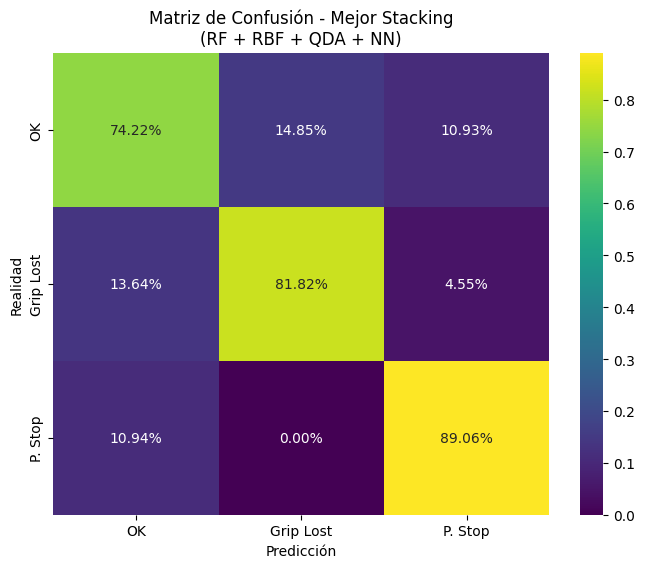

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import f1_score, classification_report, confusion_matrix

class PyTorchWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, hidden_1=64, hidden_2=32, dropout=0.2, lr=0.001, epochs=50, batch_size=32):
        self.input_dim = input_dim
        self.hidden_1 = hidden_1
        self.hidden_2 = hidden_2
        self.dropout = dropout
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None
        self.classes_ = [0, 1, 2] 
        
    def fit(self, X, y):
        self.model = RobotClassifierDynamic(self.input_dim, self.hidden_1, self.hidden_2, self.dropout)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        
        X_t = torch.tensor(X, dtype=torch.float32)
        y_np = y.to_numpy() if isinstance(y, pd.Series) else y
        y_t = torch.tensor(y_np, dtype=torch.long)
        
        ds = torch.utils.data.TensorDataset(X_t, y_t)
        loader = torch.utils.data.DataLoader(ds, batch_size=self.batch_size, shuffle=True)
        
        self.model.train()
        for epoch in range(self.epochs):
            for xb, yb in loader:
                optimizer.zero_grad()
                outputs = self.model(xb)
                loss = criterion(outputs, yb)
                loss.backward()
                optimizer.step()
        return self
    
    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X_t = torch.tensor(X, dtype=torch.float32)
            logits = self.model(X_t)
            return torch.argmax(logits, dim=1).numpy()

    def predict_proba(self, X):
        self.model.eval()
        with torch.no_grad():
            X_t = torch.tensor(X, dtype=torch.float32)
            logits = self.model(X_t)
            return torch.softmax(logits, dim=1).numpy()

#ESTIMADORES

# A. Instanciar wrapper de NN
nn_estimator = PyTorchWrapper(
    input_dim=X_train_scaled.shape[1],
    **best_params # Los best params encontrados previamente
)


estimators_pool = {
    'RF': best_rf,
    'SVC_RBF': best_rbf,
    'QDA': best_qda,
    'Logistic': best_log,
    'LinearSVC': grid_svm.best_estimator_, 
    'NeuralNet': nn_estimator
}

# B. Pre-calcular los Splits (Tu corrección clave)
sgkf = StratifiedGroupKFold(n_splits=5)
# Generamos la lista de índices (Train_idx, Val_idx) para cada fold
cv_indices = list(sgkf.split(X_train_scaled, y_train, groups=groups_train))


# Combinaciones inteligentes!

combinations_to_test = [
    ("RF + Logistic", ['RF', 'Logistic']),
    ("RF + LinearSVC", ['RF', 'LinearSVC']),
    ("RF + QDA", ['RF', 'QDA']), # Mezcla bagging con generativo

    ("RF + RBF + Logistic", ['RF', 'SVC_RBF', 'Logistic']), # Clásico
    ("RF + NN + LinearSVC", ['RF', 'NeuralNet', 'LinearSVC']), # Potencia pura

    ("RF + RBF + QDA + NN", ['RF', 'SVC_RBF', 'QDA', 'NeuralNet'])
]

# Filtrar combinaciones si falta algún modelo en el pool
valid_combinations = []
for name, keys in combinations_to_test:
    if all(k in estimators_pool for k in keys):
        # Convertimos claves a tuplas (nombre, modelo) para el Stacking
        models_list = [(k, estimators_pool[k]) for k in keys]
        valid_combinations.append((name, models_list))

# BUCLE DE ENTRENAMIENTO
results = []
best_score = -1
best_stack_model = None
best_stack_name = ""

print(f"--- INICIANDO STACKING ({len(valid_combinations)} combinaciones) ---")

for combo_name, estimators_list in valid_combinations:
    print(f"\n> Entrenando Stack: [{combo_name}] ...")
    
    # Configurar Stacking
    # Usamos n_jobs=1 si hay Red Neuronal para evitar conflictos con PyTorch
    # Si son solo modelos de sklearn, n_jobs=-1 es más rápido.
    use_n_jobs = 1 if 'NeuralNet' in [n for n, m in estimators_list] else -1
    
    stack = StackingClassifier(
        estimators=estimators_list,
        final_estimator=LogisticRegression(class_weight='balanced'), # Meta-modelo simple
        cv=cv_indices, # <--- LA CLAVE: Usamos los índices pre-calculados
        n_jobs=use_n_jobs,
        passthrough=False 
    )
    
    try:
        # Entrenar
        stack.fit(X_train_scaled, y_train)
        
        # Evaluar
        y_pred = stack.predict(X_test_scaled)
        score = f1_score(y_test, y_pred, average='macro')
        
        print(f"  --> F1-Macro: {score:.4f}")
        results.append({'Modelo': combo_name, 'F1': score})
        
        # Guardar el mejor
        if score > best_score:
            best_score = score
            best_stack_model = stack
            best_stack_name = combo_name
            
    except Exception as e:
        print(f"  [ERROR] Falló {combo_name}: {e}")

# 4. RESULTADOS Y VISUALIZACIÓN

print("\n" + "="*60)
print(f"MEJOR COMBINACIÓN: {best_stack_name}")
print(f"F1-Macro: {best_score:.4f}")
print("="*60)

# Tabla Comparativa
df_res = pd.DataFrame(results).sort_values(by='F1', ascending=False)
print("\nRanking de Combinaciones:")
print(df_res)

# Matriz de Confusión del Ganador
if best_stack_model:
    y_pred_final = best_stack_model.predict(X_test_scaled)
    
    print(f"\nReporte detallado ({best_stack_name}):")
    print(classification_report(y_test, y_pred_final))
    
    plt.figure(figsize=(8, 6))
    conf_matrix = confusion_matrix(y_test, y_pred_final, normalize='true')
    sns.heatmap(conf_matrix, annot=True, fmt='.2%', cmap='viridis',
                xticklabels=['OK', 'Grip Lost', 'P. Stop'],
                yticklabels=['OK', 'Grip Lost', 'P. Stop'])
    plt.title(f'Matriz de Confusión - Mejor Stacking\n({best_stack_name})')
    plt.ylabel('Realidad')
    plt.xlabel('Predicción')
    plt.show()

Tenemos que ajustar el Threshold, es demasiado conservador el que tenemos!

In [ ]:
confusion_matrix(y_test, y_pred_final, normalize='true')

array([[0.74215247, 0.1485426 , 0.10930493],
       [0.13636364, 0.81818182, 0.04545455],
       [0.109375  , 0.        , 0.890625  ]])

Observemos como afecta el threshold a la clase 2 para precision y recall en el train!

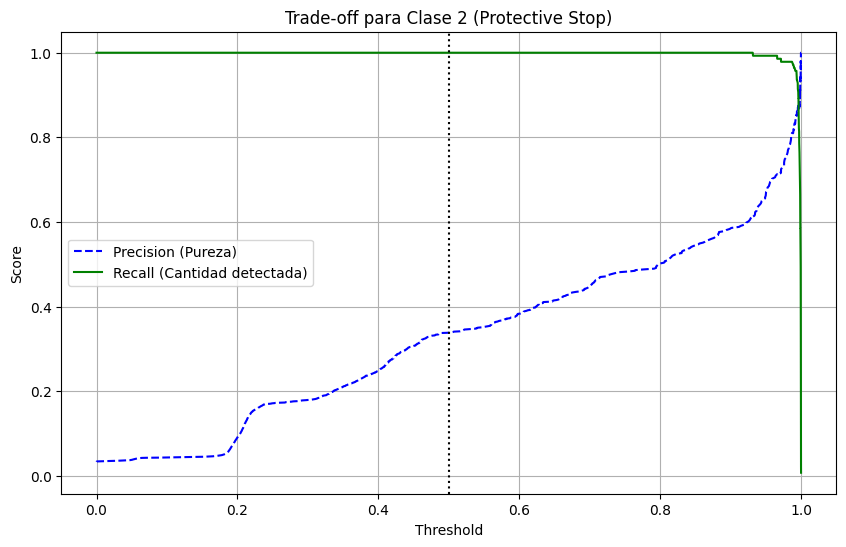

In [ ]:
from sklearn.metrics import precision_recall_curve

# 1. Probabilidades del TEST (Para ver la realidad)
y_probs = best_stack_model.predict_proba(X_train_scaled)

# Vamos a analizar la Clase 2 (Protective Stop) que es la crítica
precisions, recalls, thresholds = precision_recall_curve(y_train == 2, y_probs[:, 2])

# Dibujar la curva
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision (Pureza)")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall (Cantidad detectada)")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Trade-off para Clase 2 (Protective Stop)")
plt.legend()
plt.grid()
plt.axvline(x=0.5, color='k', linestyle=':', label='Umbral 0.5')
plt.show()

Ahora veamos como afecta en el test!

In [ ]:
from sklearn.metrics import precision_recall_curve

# 1. Probabilidades del TEST (Para ver la realidad)
y_probs = best_stack_model.predict_proba(X_test_scaled)

# Vamos a analizar la Clase 2 (Protective Stop) que es la crítica
precisions, recalls, thresholds = precision_recall_curve(y_test == 2, y_probs[:, 2])

# Dibujar la curva
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision (Pureza)")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall (Cantidad detectada)")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Trade-off para Clase 2 (Protective Stop)")
plt.legend()
plt.grid()
plt.axvline(x=0.5, color='k', linestyle=':', label='Umbral 0.5')
plt.show()

--- REPORTE ORIGINAL (Umbral implícito 0.5/Argmax) ---
              precision    recall  f1-score   support

         0.0       0.99      0.74      0.85      1784
         1.0       0.12      0.82      0.21        44
         2.0       0.22      0.89      0.36        64

    accuracy                           0.75      1892
   macro avg       0.44      0.82      0.47      1892
weighted avg       0.94      0.75      0.82      1892


--- REPORTE CON UMBRAL ALTO (0.85) ---
              precision    recall  f1-score   support

         0.0       0.98      0.92      0.95      1784
         1.0       0.33      0.68      0.45        44
         2.0       0.35      0.73      0.48        64

    accuracy                           0.91      1892
   macro avg       0.56      0.78      0.62      1892
weighted avg       0.95      0.91      0.92      1892


Nueva Matriz de Confusión:
[[0.91816143 0.03363229 0.04820628]
 [0.31818182 0.68181818 0.        ]
 [0.265625   0.         0.734375  ]]
      

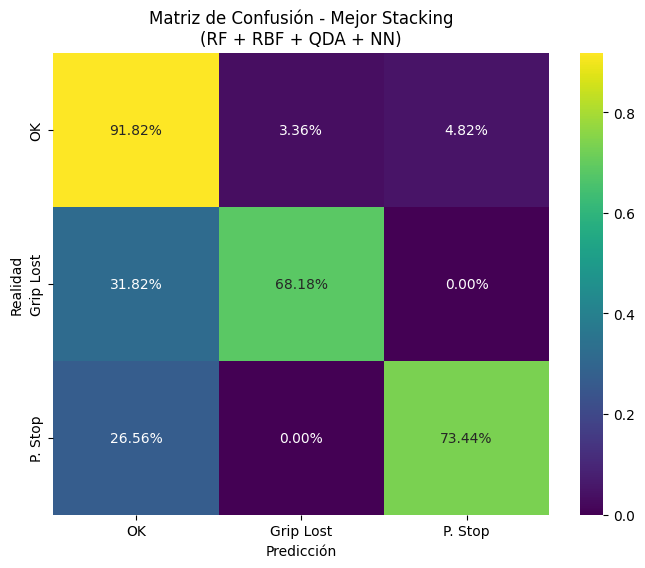

In [ ]:
# import numpy as np
# from sklearn.metrics import classification_report, confusion_matrix

# def predict_with_threshold(model, X, threshold=0.7):
#     # 1. Obtener probabilidades (N_samples, 3_clases)
#     probs = model.predict_proba(X)
    
#     # 2. Lógica personalizada
#     # Por defecto decimos que es Clase 0 (OK)
#     final_preds = np.zeros(len(X))
    
#     # 3. Solo cambiamos a Clase 1 o 2 si superan el umbral de seguridad
#     # Miramos la prob de Clase 1
#     mask_c1 = probs[:, 1] > threshold
#     final_preds[mask_c1] = 1
    
#     # Miramos la prob de Clase 2 (si es mayor que el umbral y mayor que la de clase 1)
#     mask_c2 = (probs[:, 2] > threshold) & (probs[:, 2] > probs[:, 1])
#     final_preds[mask_c2] = 2
    
#     return final_preds

# # --- PRUEBA CON DISTINTOS UMBRALES ---
# print("--- REPORTE ORIGINAL (Umbral implícito 0.5/Argmax) ---")
# print(classification_report(y_test, best_stack_model.predict(X_test_scaled)))

# print("\n--- REPORTE CON UMBRAL ALTO (0.85) ---")
# # Solo gritamos "Fallo" si estamos al 85% seguros
# y_pred_th = predict_with_threshold(best_stack_model, X_test_scaled, threshold=0.8)
# print(classification_report(y_test, y_pred_th))

# # Matriz de confusión nueva
# print("\nNueva Matriz de Confusión:")
# print(confusion_matrix(y_test, y_pred_th, normalize='true'))

# plt.figure(figsize=(8, 6))
# conf_matrix = confusion_matrix(y_test, y_pred_th, normalize='true')
# sns.heatmap(conf_matrix, annot=True, fmt='.2%', cmap='viridis',
#             xticklabels=['OK', 'Grip Lost', 'P. Stop'],
#             yticklabels=['OK', 'Grip Lost', 'P. Stop'])
# plt.title(f'Matriz de Confusión - Mejor Stacking\n({best_stack_name})')
# plt.ylabel('Realidad')
# plt.xlabel('Predicción')
# plt.show()



Calibrando umbral con datos de Entrenamiento...

--- RESULTADO DE CALIBRACIÓN ---
Mejor umbral encontrado en TRAIN: 0.97
F1-Macro teórico en TRAIN con este umbral: 0.9096

--- EVALUACIÓN EN TEST (Con umbral calibrado) ---

--- RESULTADO DE CALIBRACIÓN ---
Mejor umbral encontrado en TRAIN: 0.97
F1-Macro teórico en TRAIN con este umbral: 0.9096

--- EVALUACIÓN EN TEST (Con umbral calibrado) ---
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      1784
         1.0       0.62      0.55      0.58        44
         2.0       0.37      0.34      0.35        64

    accuracy                           0.94      1892
   macro avg       0.65      0.62      0.63      1892
weighted avg       0.94      0.94      0.94      1892

              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      1784
         1.0       0.62      0.55      0.58        44
         2.0       0.37      0.34      0.35        64

    a

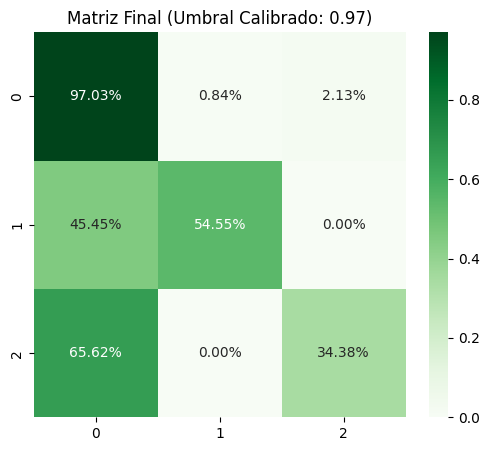

In [ ]:
from sklearn.metrics import f1_score, precision_recall_curve

# 1. Obtenemos las probabilidades del conjunto de ENTRENAMIENTO
# (Es normal que aquí dé muy buenos resultados, lo usamos solo para calibrar)
print("Calibrando umbral con datos de Entrenamiento...")
y_train_probs = best_stack_model.predict_proba(X_train_scaled)

# 2. Barrido de umbrales para encontrar el óptimo en TRAIN
thresholds = np.arange(0.1, 0.99, 0.01)
f1_scores_train = []

for t in thresholds:
    # Lógica personalizada
    preds_t = np.zeros(len(y_train))
    mask_c1 = y_train_probs[:, 1] > t
    preds_t[mask_c1] = 1
    # La clase 2 tiene prioridad si supera su umbral y es mayor que la clase 1
    mask_c2 = (y_train_probs[:, 2] > t) & (y_train_probs[:, 2] > y_train_probs[:, 1])
    preds_t[mask_c2] = 2
    
    # Guardamos F1
    score = f1_score(y_train, preds_t, average='macro')
    f1_scores_train.append(score)

# 3. Seleccionamos el mejor umbral
best_idx = np.argmax(f1_scores_train)
best_threshold_valid = thresholds[best_idx]
best_f1_train = f1_scores_train[best_idx]

print(f"\n--- RESULTADO DE CALIBRACIÓN ---")
print(f"Mejor umbral encontrado en TRAIN: {best_threshold_valid:.2f}")
print(f"F1-Macro teórico en TRAIN con este umbral: {best_f1_train:.4f}")

# 4. APLICACIÓN AL TEST (La hora de la verdad)
# Usamos el umbral que encontramos arriba, sin mirar el test hasta ahora
print("\n--- EVALUACIÓN EN TEST (Con umbral calibrado) ---")
y_test_probs = best_stack_model.predict_proba(X_test_scaled)

final_preds_test = np.zeros(len(y_test))
mask_c1_test = y_test_probs[:, 1] > best_threshold_valid
final_preds_test[mask_c1_test] = 1
mask_c2_test = (y_test_probs[:, 2] > best_threshold_valid) & (y_test_probs[:, 2] > y_test_probs[:, 1])
final_preds_test[mask_c2_test] = 2

print(classification_report(y_test, final_preds_test))

# Matriz final honesta
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, final_preds_test, normalize='true')
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Greens')
plt.title(f'Matriz Final (Umbral Calibrado: {best_threshold_valid:.2f})')
plt.show()

## Voting

--- INICIANDO VOTING CLASSIFIER (6 combinaciones) ---

> Entrenando Voting: [RF + Logistic] ...
  --> F1-Macro: 0.5140

> Entrenando Voting: [RF + QDA] ...
  --> F1-Macro: 0.5140

> Entrenando Voting: [RF + QDA] ...
  --> F1-Macro: 0.4340

> Entrenando Voting: [RF + SVC_RBF] ...
  --> F1-Macro: 0.4340

> Entrenando Voting: [RF + SVC_RBF] ...
  --> F1-Macro: 0.5326

> Entrenando Voting: [RF + RBF + Logistic] ...
  --> F1-Macro: 0.5326

> Entrenando Voting: [RF + RBF + Logistic] ...
  --> F1-Macro: 0.6129

> Entrenando Voting: [RF + NN + Logistic] ...
  --> F1-Macro: 0.6129

> Entrenando Voting: [RF + NN + Logistic] ...
  --> F1-Macro: 0.6546

> Entrenando Voting: [RF + RBF + QDA + NN] ...
  --> F1-Macro: 0.6546

> Entrenando Voting: [RF + RBF + QDA + NN] ...
  --> F1-Macro: 0.6539

MEJOR COMBINACIÓN VOTING: RF + NN + Logistic
F1-Macro: 0.6546

Ranking de Combinaciones:
                Modelo        F1
4   RF + NN + Logistic  0.654622
5  RF + RBF + QDA + NN  0.653882
3  RF + RBF + Logist

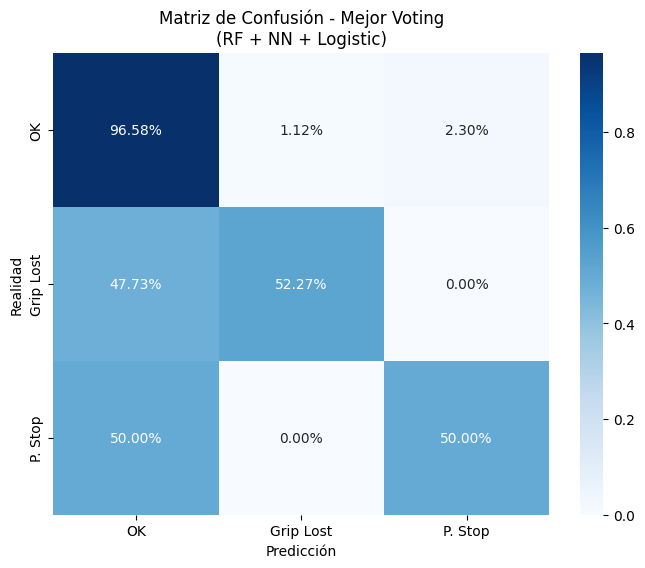

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier # <--- CAMBIO IMPORTANTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.base import BaseEstimator, ClassifierMixin
import torch
import torch.nn as nn
import torch.optim as optim

# ==========================================
# 0. WRAPPER PARA RED NEURONAL (Mantenemos tu clase)
# ==========================================
class PyTorchWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, hidden_1=64, hidden_2=32, dropout=0.2, lr=0.001, epochs=50, batch_size=32):
        self.input_dim = input_dim
        self.hidden_1 = hidden_1
        self.hidden_2 = hidden_2
        self.dropout = dropout
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None
        self.classes_ = [0, 1, 2] 
        
    def fit(self, X, y):
        self.model = RobotClassifierDynamic(self.input_dim, self.hidden_1, self.hidden_2, self.dropout)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        
        X_t = torch.tensor(X, dtype=torch.float32)
        y_np = y.to_numpy() if isinstance(y, pd.Series) else y
        y_t = torch.tensor(y_np, dtype=torch.long)
        
        ds = torch.utils.data.TensorDataset(X_t, y_t)
        loader = torch.utils.data.DataLoader(ds, batch_size=self.batch_size, shuffle=True)
        
        self.model.train()
        for epoch in range(self.epochs):
            for xb, yb in loader:
                optimizer.zero_grad()
                outputs = self.model(xb)
                loss = criterion(outputs, yb)
                loss.backward()
                optimizer.step()
        return self
    
    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            X_t = torch.tensor(X, dtype=torch.float32)
            logits = self.model(X_t)
            return torch.argmax(logits, dim=1).numpy()

    def predict_proba(self, X):
        self.model.eval()
        with torch.no_grad():
            X_t = torch.tensor(X, dtype=torch.float32)
            logits = self.model(X_t)
            return torch.softmax(logits, dim=1).numpy()

# ==========================================
# 1. PREPARACIÓN DE ESTIMADORES
# ==========================================

# A. Instanciar wrapper de NN
nn_estimator = PyTorchWrapper(
    input_dim=X_train_scaled.shape[1],
    **best_params 
)

# B. Aseguramos que el SVM RBF tenga probabilidad activada
best_rbf.probability = True

# C. Pool de Estimadores Disponibles
estimators_pool = {
    'RF': best_rf,
    'SVC_RBF': best_rbf,
    'QDA': best_qda,
    'Logistic': best_log,
    # 'LinearSVC': NO LO INCLUIMOS porque rompe el Voting Soft (no tiene predict_proba)
    'NeuralNet': nn_estimator
}

# Filtramos los que sean None
estimators_pool = {k: v for k, v in estimators_pool.items() if v is not None}

# ==========================================
# 2. DEFINIR COMBINACIONES ESTRATÉGICAS
# ==========================================

combinations_to_test = [
    # --- NIVEL 1: PAREJAS ---
    ("RF + Logistic", ['RF', 'Logistic']),
    ("RF + QDA", ['RF', 'QDA']), 
    ("RF + SVC_RBF", ['RF', 'SVC_RBF']),

    # --- NIVEL 2: TRÍOS ---
    ("RF + RBF + Logistic", ['RF', 'SVC_RBF', 'Logistic']),
    ("RF + NN + Logistic", ['RF', 'NeuralNet', 'Logistic']), 
    
    # --- NIVEL 3: ALL STARS ---
    ("RF + RBF + QDA + NN", ['RF', 'SVC_RBF', 'QDA', 'NeuralNet'])
]

# Filtrar combinaciones válidas
valid_combinations = []
for name, keys in combinations_to_test:
    if all(k in estimators_pool for k in keys):
        models_list = [(k, estimators_pool[k]) for k in keys]
        valid_combinations.append((name, models_list))

# ==========================================
# 3. BUCLE DE ENTRENAMIENTO (VOTING)
# ==========================================
results = []
best_score = -1
best_voting_model = None
best_voting_name = ""

print(f"--- INICIANDO VOTING CLASSIFIER ({len(valid_combinations)} combinaciones) ---")

for combo_name, estimators_list in valid_combinations:
    print(f"\n> Entrenando Voting: [{combo_name}] ...")
    
    # Configurar n_jobs
    use_n_jobs = 1 if 'NeuralNet' in [n for n, m in estimators_list] else -1
    
    # VOTING CLASSIFIER (SOFT)
    # Usamos 'soft' para promediar probabilidades (suele ser mejor para F1)
    voting_clf = VotingClassifier(
        estimators=estimators_list,
        voting='soft', 
        n_jobs=use_n_jobs
    )
    
    try:
        # Entrenar (Directamente en Train, no necesita CV interno)
        voting_clf.fit(X_train_scaled, y_train)
        
        # Evaluar
        y_pred = voting_clf.predict(X_test_scaled)
        score = f1_score(y_test, y_pred, average='macro')
        
        print(f"  --> F1-Macro: {score:.4f}")
        results.append({'Modelo': combo_name, 'F1': score})
        
        # Guardar el mejor
        if score > best_score:
            best_score = score
            best_voting_model = voting_clf
            best_voting_name = combo_name
            
    except Exception as e:
        print(f"  [ERROR] Falló {combo_name}: {e}")

# ==========================================
# 4. RESULTADOS Y VISUALIZACIÓN
# ==========================================

print("\n" + "="*60)
print(f"MEJOR COMBINACIÓN VOTING: {best_voting_name}")
print(f"F1-Macro: {best_score:.4f}")
print("="*60)

# Tabla Comparativa
df_res = pd.DataFrame(results).sort_values(by='F1', ascending=False)
print("\nRanking de Combinaciones:")
print(df_res)

# Matriz de Confusión del Ganador
if best_voting_model:
    y_pred_final = best_voting_model.predict(X_test_scaled)
    
    print(f"\nReporte detallado ({best_voting_name}):")
    print(classification_report(y_test, y_pred_final))
    
    plt.figure(figsize=(8, 6))
    conf_matrix = confusion_matrix(y_test, y_pred_final, normalize='true')
    sns.heatmap(conf_matrix, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=['OK', 'Grip Lost', 'P. Stop'],
                yticklabels=['OK', 'Grip Lost', 'P. Stop'])
    plt.title(f'Matriz de Confusión - Mejor Voting\n({best_voting_name})')
    plt.ylabel('Realidad')
    plt.xlabel('Predicción')
    plt.show()